# Init Tdx 

In [1]:
# import logging
import sys

# stdout=sys.stdout
sys.path.append('../../')
import os
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
# pip install --upgrade mplfinance
# sys.stdout=stdout
import numpy as np
# import numpy as np
import pandas as pd
from JohnsonUtil import commonTips as cct
from JohnsonUtil import johnson_cons as ct
from JSONData import sina_data
from JSONData import tdx_data_Day as tdd
from mplfinance.original_flavor import candlestick_ohlc

# from JSONData import tdx_hdf5_api as h5a

%matplotlib widget
plt.rc('font', family='SimHei', size=13)
matplotlib.get_backend()
# jupyter nbextension enable --py widgetsnbextension

os.environ['NUMEXPR_MAX_THREADS'] = '12'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import nest_asyncio

nest_asyncio.apply()

In [2]:
# code_list = sina_data.Sina().all.index.tolist()
# print(f'code_list:{len(code_list)}')
# df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start=20170101, end=None,freq=None, col=None, index='date')

In [3]:
block_path = tdd.get_tdx_dir_blocknew() + '060.blk'

## 功能定义DEF

### ra_diff


In [4]:
def ra_diff(df):
    df['ra_diff'] = df.close.apply(lambda x: round(x / df.close.min(), 2))
    return df

### bullish 测算

In [5]:
import numpy as np


def calculate_slope(data):
    # Calculate the slope of the line that connects two points
    slope = round((data[1] - data[0]) / (1), 2)
    return slope


def detect_bull_bear(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    for i in range(len(price_data) - window, len(price_data) - 1):
        slope = calculate_slope([price_data[i], price_data[i + 1]])
        # print(slope)
        slopes.append(slope)

    # Compare the current slope with the average slope of the last `window` days
    avg_slope = round(np.mean(slopes), 2)
    curr_slope = calculate_slope([price_data[-window], price_data[-1]])
    print(len(slopes), avg_slope, curr_slope)

    if curr_slope > avg_slope:
        # return "Bullish"
        return "Bull"
    else:
        return "Bear"


def detect_bull_bear_apply(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    # try:
    if len(price_data) > 20:
        for i in range(len(price_data) - window, len(price_data) - 1):
            slope = calculate_slope([price_data[i], price_data[i + 1]])
            # print(slope)
            slopes.append(slope)

        # Compare the current slope with the average slope of the last `window` days
        avg_slope = round(np.mean(slopes), 2)
        curr_slope = calculate_slope([price_data[-window], price_data[-1]])
        # print(len(slopes), avg_slope, curr_slope)

        # if curr_slope > avg_slope:
        #     # return "Bullish"
        #     return "Bull"
        # else:
        #     return "Bear"
        return curr_slope
    else:
        return round((price_data[-1] - price_data[0]) / (1), 2)


code = '601360'
# Example usage
# price_data = [100, 95, 97, 99, 102, 105, 108, 111,1]
dfc = tdd.get_tdx_Exp_day_to_df(
    code, dl=60, resample='d').sort_index(
    ascending=True).reset_index()
# dfc = get_sina_data_cname(dfc)
price_data = dfc.close.values.tolist()
price_data[1], dfc.date[0]
price_data[-1], dfc.date[-1:]
print(detect_bull_bear(price_data))
print(detect_bull_bear_apply(price_data))

# Output: "Bullish"

(10.01, '2025-06-13')

(10.58,
 59    2025-09-04
 Name: date, dtype: object)

9 -0.11 -0.99
Bear
-0.99


### regression_line(X, Y)
regression_ratio(df, window=10):

9.79 0.03
Above
0.03


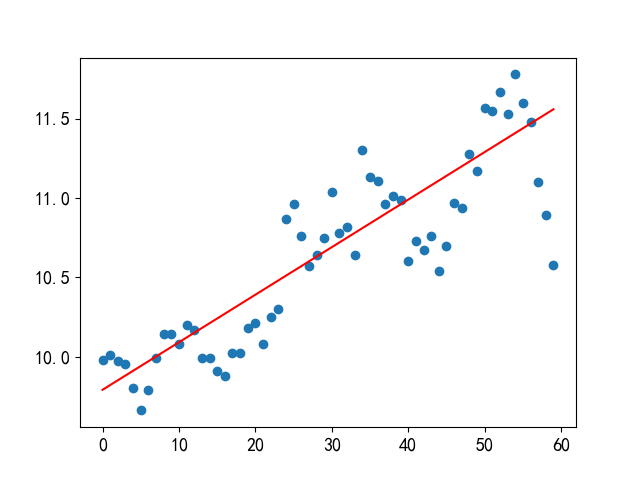

In [6]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

9.79 0.03
Above
0.03


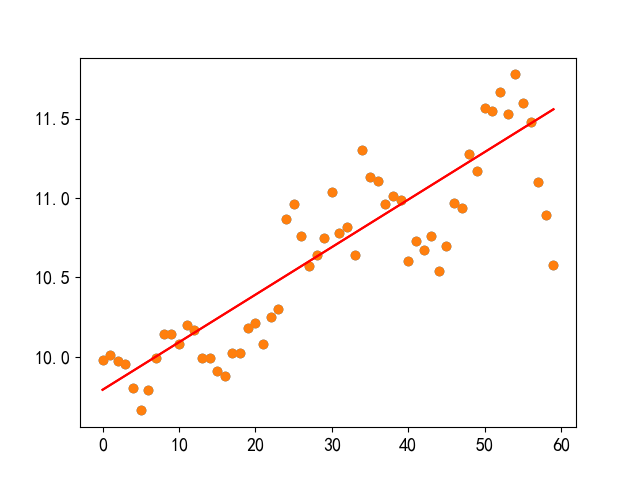

In [7]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

In [8]:
dfc.columns

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount',
       'lower', 'ene',
       ...
       'max5', 'max10', 'hmax', 'hmax60', 'high4', 'llowvol', 'low10', 'low60',
       'low4', 'lastdu4'],
      dtype='object', length=175)

### check_postion_vol_price

In [9]:
from sklearn.linear_model import LinearRegression


def check_postion_vol_price(df):
    # 加载数据
    # df = pd.read_csv("data.csv")

    # 创建输入数据
    X = df[["close", "vol"]].values
    y = df["close"].values

    # 训练回归模型
    reg = LinearRegression().fit(X, y)

    # 计算斜率和截距
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # 计算上轨和下轨
    upper_band = slope * df["close"] + intercept + 2 * df["vol"]
    lower_band = slope * df["close"] + intercept - 2 * df["vol"]

    # 判断价格是否在通道内
    df["Positon"] = np.where(
        df["close"] > upper_band, "Long", np.where(
            df["close"] < lower_band, "Short", "Neutral"))
    return df


dfc = check_postion_vol_price(dfc)
dfc[-1:]

date    code   open   high    low  close          vol        amount  \
59  2025-09-04  601360  10.91  11.05  10.43  10.58  148483798.0  1.595247e+09   

    lower   ene  ...  max10   hmax  hmax60  high4     llowvol  low10  low60  \
59   10.3  11.1  ...  11.78  11.78   10.96   11.6  82439272.0  10.89   9.66   

    low4  lastdu4  Positon  
59  10.8      5.9  Neutral  

[1 rows x 176 columns]

In [10]:

# dfc=  dfc.rename(columns={'date': 'Date', "open":"Open","high":"High","low": "Low","close":"Close"})
dfc.columns
# dfc[["Date", "Open", "High", "Low", "Close"]][-2:]
dfc.date[:3]
dfc.date = pd.to_datetime(dfc.date)
# dfc.set_index('date')
dfc.date[-1:]

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount',
       'lower', 'ene',
       ...
       'max10', 'hmax', 'hmax60', 'high4', 'llowvol', 'low10', 'low60', 'low4',
       'lastdu4', 'Positon'],
      dtype='object', length=176)

0    2025-06-13
1    2025-06-16
2    2025-06-17
Name: date, dtype: object

59   2025-09-04
Name: date, dtype: datetime64[ns]

### show_ohlc_upper 

xratio:0.03 
code: 601360


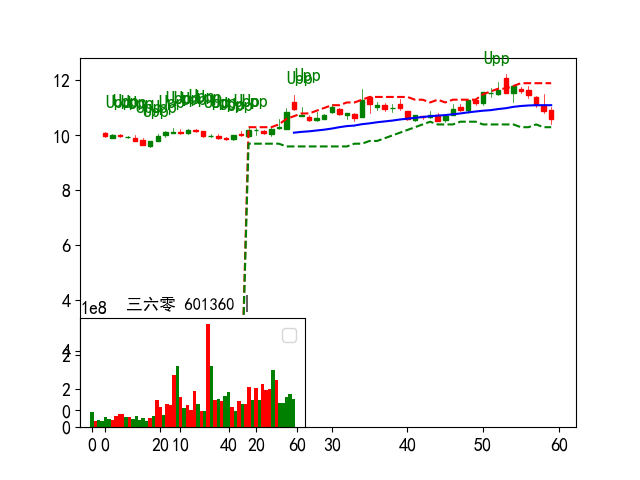

In [11]:

def show_ohlc_upper(df, code=None, allshow=True):
    # 加载数据
    # df = pd.read_csv("data.csv")
    # plt.close()
    # 计算OHLC数据
    # df = df.rename(columns={'date': 'Date', "open": "Open",
    #                "high": "High", "low": "Low", "close": "Close"})
    # df.Date = df.Date.apply(lambda x:str(x).replace('-',''))
    if 'name' not in df.columns and code is not None:
        df['name']= tdd.get_sina_data_code(code)
    if allshow:
        if 'ra_diff' in df.columns:
            print("xratio:%s ra_diff:%s" % (regression_ratio(df),df.ra_diff[-1]))
        else:
            print("xratio:%s " % (regression_ratio(df)))
    # df=df[df.upper > 0]
    df = df.rename(columns={'vol': 'volume'})
    df = df.reset_index()
    # df.date = pd.to_datetime(df.index)
    df.date = df.index
    # print(df.Date)
    # ohlc = df[["Date", "Open", "High", "Low", "Close"]].values
    ohlc = df[["date", "open", "high", "low", "close", 'volume']].values

    # 计算上轨和下轨
    # upper_band = df[df.upper != 0].upper
    # lower_band = df[df.lower != 0].lower
    upper_band = df.upper
    lower_band = df.lower
    
    # print(lower_band,df.lower)
    # print(upper_band,df.upper)

    if 'ma20d' in df.columns:
        ma20d = df[df.ma20d > 0].ma20d
    elif 'ma20' in df.columns:
        ma20d = df[df.ma20 > 0].ma20
    else:
        print('not ma20 ma20d')
    idx = len(df) - len(upper_band)
    idx2 = len(df) - len(lower_band)
    if idx != idx2:
        print(idx, len(df), len(upper_band))
        print(idx2, len(lower_band))

    # 计算当前价格的位置
    position = ['' for i in range(len(df))]
    # print(idx,len(df) ,len(upper_band),position)
    
        # else:
            # position[i] = 'Middle Band'
    # print(position)
    # 绘制OHLC图
    fig, ax = plt.subplots()
    candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')

    # 添加上轨和下轨
    
    for i in range(idx, len(upper_band), 1):
        # print(df["close"][i])
        # print(upper_band[i],df["low"][i])
        # print(i,lower_band[i])
        #error upper_band ==0.0
        if df["close"][i] > upper_band[i]:
            position[i] = 'Upp'
        elif df["low"][i] < lower_band[i]:
            position[i] = 'Low'
            
    plt.plot(upper_band.index, upper_band, 'r--', label='Upper Band')
    plt.plot(lower_band.index, lower_band, 'g--', label='Lower Band')
    
    plt.plot(ma20d.index, ma20d, 'b', label='ma20')

    if 'hat' in df.columns:
        plt.plot(df.hat.index, df.hat, 'g', label='hat')
    # 添加位置
    for i, txt in enumerate(position):
        if txt == 'Low':
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, -30), textcoords='offset points', color='g')
        else:
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, 20), textcoords='offset points', color='g')
    axx = fig.add_subplot(325)
    # axx.plot(df[["volume"]])
    # from matplotlib import transforms
    # pad = 0.25
    # yl = ax.get_ylim()
    # ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
    # axx = ax.twinx()
    # axx.set_position(transforms.Bbox([[0.125,0.1],[0.9,0.32]]))

    volume = np.asarray(df.volume)
    pos = df['open'] - df['close'] < 0
    neg = df['open'] - df['close'] >= 0
    idx = np.asarray([x for x in range(len(df.date))])
    # print len(dates),len(df),ax.get_xlim(),ax.get_xticks()
    axx.bar(idx[pos], volume[pos], color='red', width=1, align='center')
    axx.bar(idx[neg], volume[neg], color='green', width=1, align='center')

    # position = ['' for i in range(len(df))]
    # position = df.Positon
    # for i, txt in enumerate(position):
    #     plt.annotate(txt, (df["Date"][i], df["Close"][i]), xytext=(0,20), textcoords='offset points')
    # 添加图例
    plt.legend(loc='best')
    # plt.legend(["Now:%s" % df.close[-1], "Hi:%s" % df.high[-1], "Lo:%0.2f" % (asset.iat[-1]), "day:%s" %
    #             len(asset), "fib:%s" % (fib),"MA:%s"%(roll_mean_days)], fontsize=12, loc=0)
    if 'name' in df.columns:
        if 'code' in df.columns:
            plt.title(df.name.values[-1:][0] + " " + df.code[0] + " | ", fontsize=12)
        else:
            plt.title(str(df.name.values[-1:][0]) + " " + " | ", fontsize=12)

    else:
        if 'code' in df.columns:
            plt.title(" | " + df.code[0] + " | ", fontsize=12)
        else:
            if code is None:
                plt.title(" | " + " | ", fontsize=12)
            else:
                plt.title(" | " + code + " | ", fontsize=12)

    # 显示图形
    print("code:",code)
    plt.show()


show_ohlc_upper(dfc,code=dfc.code[0])

In [12]:
'code' in dfc.columns

True

### show_channel_mpl

In [13]:
dfc['position'] = 0


def show_channel_mpl_bug(df, limit=60):
    # Compute the channel
    def compute_channel(df):
        # Compute the high and low of the past n periods
        n = 20
        high = df['high'].rolling(window=n, min_periods=n).max()
        low = df['low'].rolling(window=n, min_periods=n).min()
        df['upper_channel'] = high + (high - low) * 0.5
        df['lower_channel'] = low - (high - low) * 0.5

        # Update the position based on the current price
        df['position'] = np.where(df['close'] > df['upper_channel'] * 0.66, 1,
                                  np.where(df['close'] < df['lower_channel'], -1, 0))
        # print(df['position'])

    df = df.rename(columns={'vol': 'volume'})
    # df = df.reset_index()
    if 'date' in df.columns:
        df.date = pd.to_datetime(df.date)
    else:
        df = df.reset_index()
        df.date = pd.to_datetime(df.date)
    df = df.set_index('date')
    # df.date = df.index
    df = df.loc[:, ["open", "high", "low", "close", 'volume']]
    compute_channel(df)

    # fig, ax = plt.subplots()
    # Plot the ohlc chart
    mpf.plot(df, type='candle', title='OHLC chart with channel and position',
             ylabel='Price', volume=True, mav=(10, 20),
             show_nontrading=False, ylabel_lower='Position')
    # returnfig=True)
    # for i, txt in enumerate(df.position):
    #     # print(i,txt,df.index[i], df["close"][i])
    #     if txt == 0:
    #         plt.annotate("Down", (df.index[i], df["close"][i]), xytext=(
    #             0, -30), textcoords='offset points', color='g')
    #     else:
    #         plt.annotate("UP", (df.index[i], df["close"][i]), xytext=(
    #             0, 20), textcoords='offset points', color='g')

    # axlist[0].set_yticks([-1, 0, 1])
    # axlist[2].xaxis.set_ticks(df['position'])
    # axlist[2].set_xticklabels(df['upper_channel'])
    # yticks=[-1, 0, 1], yticklabels=['Sell', 'Hold', 'Buy'],
    # overlays=[(df['upper_channel'], None), (df['lower_channel'], None)])
# show_channel_mpl(dfc)

## TDX def

In [14]:
global sina_dm
sina_dm = None


def get_sina_data_cname(df, dm=None, index=False, realtime=False):
    # index_status=False
    global sina_dm
    if dm is None:
        if sina_dm is None:
            dm = sina_data.Sina().market('all')
        else:
            dm = sina_dm.copy()

    if 'ticktime' in df.columns:
        time_l = time.mktime(dm.loc[:, 'ticktime'][-1].timetuple())
        dur = round((time.time() - time_l) / 60, 2)
        if dur > 5:
            print("timel > 5,renew dm")
            dm = sina_data.Sina().market('all')
            sina_dm = dm.copy()

    if realtime:
        print("compute percent")
        df.rename(columns={'low': 'llow',
                  'high': 'lhigh', 'open': 'lopen'}, inplace=True)
        if 'nclose' in dm.columns:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:,
                 ['nclose', 'close', 'name', 'open', 'high', 'low', 'llastp',
                  'ticktime']],
                clean=True)
        else:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:, ['close', 'name', 'open', 'high', 'low', 'llastp', 'ticktime']],
                clean=True)
        dd['perc'] = ((dd['close'] - dd['llastp']) / dd['llastp'] *
                      100).map(lambda x: round(x, 2))
        # dd = cct.combine_dataFrame(df, dm['name'])

    else:
        dd = cct.combine_dataFrame(df, dm['name'])
    # cname = sina_data.Sina().get_code_cname(code)
    return dd


def write_code_to_blk(codew, blk='060'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))
    return True

def get_multiIndex_drop_last_row(df,dropline=1):

    return df.drop(level='date', labels=df.index.get_level_values('date')[-dropline])

def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df

def clean_sina_dm(dd):
    if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
        dd = dd[dd.close > 0]
    else:
        dd = dd[dd.open > 0]
    return dd

def compute_perd_value(df, market_value=3, col="vol", col_new='volsum'):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col)) &
                (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col_new, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def show_tdx_data(df, codelist=None, market_value='3', col=None,limit=20,orderby='percent'):
    col_src = [
        "name",'percent', "couts", "date", "perc", "ra_diff","xratio", "idx", "hat", "close",
        "volsum5d", "hmax", "lmin", "perc1d", "ma20", "ma250", "nclose",
        "llow", 'vol1d', 'vol2d', 'vol3d', 'vol4d', 'vol5d', "perc%sd" %
        (market_value),
        "perc5d"]
    if df is None:
        print('df is None')
        return df
    if 'close' in df.columns:
        df = df.query('close > 0')
    if isinstance(df, pd.Series):
        col_name = [co for co in col_src if co in df.index]
        # col_name.insert(1,'date')
    else:
        col_name = [co for co in col_src if co in df.columns]

    # print(col_name)
    # if isinstance(df, pd.DataFrame) and 'name' in df.columns:
    #     columns_ = col_name
    # else:
    #     if isinstance(df, pd.Series) and 'name' in df.index:
    #         columns_ = col_name.insert(1, "date")
    #     else:
    #         columns_ = col_name.remove("name")
    if orderby in df.columns:
        df=df.sort_values('percent', ascending=False)
    if isinstance(col,list):
        col_name.extend(col)
    elif col is not None:
        col_name.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            print("Count:1")
            temp = df.loc[col_name][:limit]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, col_name][:limit]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], col_name][:limit]
    return temp

def get_multi_date_duration(df, dt):
    dd = df.reset_index()
    dd = dd[dd.date >= dt]
    # dd['couts'] = dd.groupby(['code'])['code'].transform('count')
    dd = dd.set_index(['code', 'date'])
    return dd


def get_multi_code_count(df, col='code'):
    dd = df.reset_index()
    dd['couts'] = dd.groupby([col])[col].transform('count')
    dd = dd.sort_values(by=['couts', 'date'], ascending=[0, 1])
    print('count dd.couts')
    dd = dd.set_index(['code', 'date'])
    return dd


def multindex_iloc(df, index):
    label = df.index.levels[0][index]
    return df.iloc[df.index.get_loc(label)]


def get_groupby_mean_median_close(dfs):

    groupd = dfs.groupby(level=[0])

    df = groupd['close'].agg(['median', 'mean'])
    df['close'] = groupd.tail(1).reset_index().set_index(['code'])['close']
    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # dfs = dfs.fillna(0)
    # idx = pd.IndexSlice
    # mask = ( (dfs['mean'] > dfs['median'])
    #         & (dfs['close'] > dfs['mean'])
    #         )
    # df=dfs.loc[idx[mask, :]]

    df = df[(df['mean'] > df['median']) & (df['close'] > df['mean'])]

    # dt_low = None
    # if dl == 1:
    #     dfs = groupd.tail(1)
    #     print("dfs tail1")
    # else:
    #     dl = 30
    #     dindex = tdd.get_tdx_Exp_day_to_df(
    #         '999999', dl=dl).sort_index(ascending=False)
    #     dt = tdd.get_duration_price_date('999999', df=dindex)
    #     dt = dindex[dindex.index >= dt].index.values
    #     dt_low = dt[-1]
    #     dtlen = len(dt) if len(dt) >0 else 1
    #     dfs = groupd.tail(dtlen)
    #     print("dfs tail:%s dt:%s"%(dtlen,dt))
    #     dfs = get_multi_date_duration(dfs,dt[-1])
    return df


def compute_df_Col_lastday(dfs, col='close', colre='perc', days=3, plus=True):
    for da in range(int(days)):
        da += 1
        if plus:
            dfs['%s%sd' % (colre, da)] = round(
                (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
        else:
            if da == 1:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
            else:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col].shift(da - 1) - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
    return dfs

In [15]:
def get_roll_mean_all(
        single=True, tdx=False, app=True, duration=100, ma_250_l=1.3,
        ma_250_h=1.3, resample='d'):
    time_s = time.time()
    if not app and cct.get_file_size(block_path) > 100 and cct.creation_date_duration(block_path) == 0:
        print("It's Today Update")
        return True
    code_list = sina_data.Sina().all.index.tolist()
#     .Sina().all.index.tolist()
    code_list.extend(['999999', '399001', '399006'])
    print("all code:", len(code_list))
    if duration < 300:
        h5_fname = 'tdx_all_df' + '_' + str(300)
        h5_table = 'all' + '_' + str(300)
    else:
        h5_fname = 'tdx_all_df' + '_' + str(900)
        h5_table = 'all' + '_' + str(900)
    print(f'h5_fname:{h5_fname} h5_table:{h5_table}')
#     df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start='20170501', end=None, freq=None, col=None, index='date')
#     df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None, code_l=code_list, start=None, end=None,
#         freq=None, col=None, index='date')
    df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start=20170101, end=None,freq=None, col=None, index='date')
    # df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None,code_l=code_list, start=None, end=None, freq=None, col=None, index='date',tail=1)
    print(f'df:{df}')
    code_uniquelist = df.index.get_level_values('code').unique()

    code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]
    print(round(time.time() - time_s, 2), df.index.get_level_values(
        'code').unique().shape, code_select, df.loc[code_select].shape)
    # df.groupby(level=[0]),df.index.get_level_values(0)
    # len(df.index.get_level_values('code').unique())
    # df = df[~df.index.duplicated(keep='first')]

    # multiIndex_func = {'close': 'mean', 'low': 'min', 'high': 'max', 'volume': 'sum', 'open': 'first'}
    # cct.using_Grouper(df, freq='W', col={'close': 'last'})
    # *** TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
    # roll_dl = duration
    if resample != 'd':

        print("resample:%s"%(resample.upper()))
        df = df.groupby(level=0).resample(resample, level=1).last()
        df = df.dropna()
        
    ''' 
    if resample != 'd':
        print("resample:%s" % (resample.upper()))
        # ohlc_dict = {'volume': 'sum','high': 'max','low': 'min','close': 'last'}
        # {'low': 'min', 'close':'mean'}
        # df = df.groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        df = df.loc[:, ['close']].groupby(level=0).resample(
            resample, level=1).agg({'close': 'last'}).dropna()

        df = df.dropna()
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1, how={'low': 'min', 'close':'mean'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.Grouper(freq=resample)).transform(np.cumsum).resample(resample, how='ohlc')

        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.TimeGrouper(resample)).transform(np.cumsum).resample(resample, how='ohlc')
        # r1 = len(df.loc['000001'])
        # r2 = len(df.loc['999999'])
        # roll_dl = r1 if r1 < r2 else r2

        # df['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
        # df['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
        # df['ene'] = map(lambda x, y: round((x + y) / 2, 1), df.upper, df.lower)
        # dfs['amount%d'%cumdays] = groupd['amount'].apply(pd.rolling_mean, cumdays)
    # df.ix[df.index.levels[0]]
    # df.ix[df.index[len(df.index)-1][0]] #last row
    # dfs = tdd.search_Tdx_multi_data_duration(df=dfs,code_l=code_list, start='20170918', end='20170918', freq=None, col=None, index='date')

    # print dfs[:1],len(dfs)
    # groupd.agg({'low': 'min'})
    #  idx mask filter 
    # h5a.write_hdf_db('all300', df, table='roll200', index=False,baseCount=500, append=False, MultiIndex=MultiIndex)
    '''

    df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code', 'date'])
    print("use time:%s" % (round(time.time() - time_s, 2)))
    return df

# 读取数据 TDX Days

## resample = 'D'

In [16]:
# resample = 'W-FRI'
resample = 'D'

df = get_roll_mean_all(
    single=False, tdx=True, app=True, duration=250, ma_250_l=1.2,
    ma_250_h=1.2, resample=resample)


# df= df.groupby(level=[0]).tail(1).reset_index().set_index('code')
# df_cname = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# df = df.reset_index().set_index(['code', 'date'])

all code: 5200
h5_fname:tdx_all_df_300 h5_table:all_300
df:                      open     high      low    close          vol  \
code   date                                                          
999999 2023-11-02  3028.00  3038.00  3010.00  3010.00  268794592.0   
       2023-11-03  3012.00  3040.00  3012.00  3030.00  268486336.0   
       2023-11-06  3048.00  3058.00  3038.00  3058.00  372949632.0   
       2023-11-07  3052.00  3064.00  3042.00  3058.00  326853440.0   
       2023-11-08  3052.00  3062.00  3038.00  3052.00  335677824.0   
...                    ...      ...      ...      ...          ...   
301519 2025-09-04    13.77    14.09    13.62    13.89    2877514.0   
300472 2025-09-04     6.01     6.18     5.67     5.85   16385053.0   
301502 2025-09-04    53.00    54.00    50.00    50.91    1859931.0   
301008 2025-09-04    34.31    36.28    33.59    34.62   14038831.0   
301388 2025-09-04    31.23    31.89    30.30    30.56    2421473.0   

                         amoun

In [17]:
# df.loc['399001'][-1:]
df.loc['000002'][-1:]
# df.groupby(level=[0]).tail(30).groupby(level=[0]).tail(2)
# df.groupby(level=[0]).tail(30).groupby(level=[0]).head(1)

open  high   low  close          vol        amount
date                                                          
2025-09-04  6.59   6.6  6.48   6.53  153722512.0  1.005295e+09

### Test InStock

In [18]:
df.loc['301083'][:2]

open   high    low  close        vol       amount
date                                                          
2023-11-02  15.78  16.22  15.50  15.50  1845500.0   29343732.0
2023-11-03  15.86  17.83  15.73  16.91  9484947.0  160420160.0

## ra_diff

In [19]:
tail_days = 60

In [20]:
df = df.groupby(level=[0]).tail(tail_days).groupby(level=[0]).apply(ra_diff)


In [21]:
# df.loc['999999'][-3:]
# df.loc['301073'].ra_diff[-3:]
df.loc['300459'].shape

(60, 7)

## X df_regression_ratio outdate
    df_idx_detect

In [22]:
# df_reg_ratio = df.groupby(level=[0])['close'].apply(regression_ratio)
# df_idx_detect = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
# show_ohlc_upper()
# df[:10]

In [23]:
# df_idx_detect.shape, df_idx_detect.loc['000002']
# df.loc['000002'][-2:],df_reg_ratio.loc['000002']
# df.loc['688798'][-3:]

In [24]:
# df.loc['000002'][-10:]

## sina_dm

In [25]:
sina_dm = sina_data.Sina().market('all')
lastday = cct.last_tddate()
lastday,sina_dm.name[:1]
sina_dm = clean_sina_dm(sina_dm)

('2025-09-04',
 code
 002127    南极电商
 Name: name, dtype: object)

In [26]:
cct.get_time_to_date(time.time(), format='%Y-%D %H:%M:%S')

# abc=dm.loc[:,'ticktime'][-1]
sina_dm.ticktime[-2:]
# dm.ticktime[:1]
# sina_dm.loc[:, 'ticktime'][-1]
# time.strptime(abc,format='%Y-%m-%d %H:%M:%S')
# (time.mktime(abc.timetuple()))
(time.time() - time.mktime(sina_dm.loc[:, 'ticktime'][-1].timetuple())) / 60

'2025-09/04/25 23:30:33'

code
600620   2025-09-04 15:00:02
002043   2025-09-04 15:00:00
Name: ticktime, dtype: datetime64[ns]

510.5552966912588

### Combine ratio and idx

In [27]:
# if 'date' in df.columns:
#     print('error duplicated date col')
#     if isinstance(df,pd.MultiIndex):
#         df.drop('date', axis=1, inplace=True)
# else:
#     df = df.reset_index().set_index('code')
#     df['idx'] = df_idx_detect
#     df['xratio'] = df_reg_ratio
#     df['name'] = sina_dm.name
#     df = df.reset_index().set_index(['code', 'date'])

## 读取实时成交量数据

In [28]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df

def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if len(store.keys()) > 0 and root is None and store is not None:
        root = store.keys()[0].replace("/", "")
        df = store[root]
        df = apply_col_toint(df)
    else:
        df = None
    store.close()
    return df

In [29]:
# tdx_path = "G:\\tdx_last_df.h5"
# from JohnsonUtil import commonTips as cct
sina_MultiD_path = f"{cct.get_ramdisk_dir()}\\sina_MultiIndex_data.h5".replace('\\',os.sep)
print(f'sina_MultiD_path:{sina_MultiD_path}')
h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
if h5 is not None:
    h5.shape
    h5code='603019'
    h5.loc[h5code][-3:]
    code_muti = '603019'
    # h5.loc[code_muti][:2]

    freq = 'D'
    # freq = '5M'
    startime = '09:25:00'
    endtime = '15:01:00'

    time_ratio = cct.get_work_time_ratio()
    time_ratio
    run_col = ['close', 'volume']
    # run_col = ['close']
    mdf = cct.get_limit_multiIndex_freq(
        h5, freq=freq.upper(),
        col=run_col, start=startime, end=endtime, code=None)
    allvol = mdf.volume.sum()
    allvol = round(allvol / 10 / 1000 / 1000,2)
    print("总量:%s 亿"%(allvol))
    mdf['vol']=mdf['volume'].apply(lambda x: round(x /1000/1000,2)) 
    mdf['amount']=(mdf.volume * mdf.close).map(lambda x: round(x/100/1000/1000, 2))
    #全局占比
    mdf['volume'] = mdf.amount.apply(
        lambda x: round(x / allvol * 100 / time_ratio, 2))
    mdf=mdf.reset_index().set_index('code')
    mdf.loc[h5code]
else:
    mdf = None

sina_MultiD_path:G:\sina_MultiIndex_data.h5
[]
G:\sina_MultiIndex_data.h5


In [30]:
if mdf is not None:
    mdf[:2]
    mdf.loc['603019']

In [31]:
# h5.index.get_level_values('code')[0]
# help(h5.index.get_level_values)
if h5 is not None:
    str(h5.index.get_level_values(1)[-1])[:10]

In [32]:
if mdf is not None and len(mdf) > 0:
    mdf.loc['000002']
else:
    print("mdf is None")

mdf is None


###  实时成交量个股Top!!!  (重点)

In [33]:
if mdf is not None and len(mdf) > 0:
    nowdf = mdf.sort_values(by=['volume'], ascending=[0])
    # nowdf.shape, df.shape, code_idx.shape
    # top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
    top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
    top20_nd=get_sina_data_cname(top20_nd)
    # nowdf.shape,top20_nd
else:
    top20_nd = None

In [34]:
# top20_nd

In [35]:
show_tdx_data(top20_nd)
# top20_nd.columns

df is None


### 合并实时成交量及SinaDM

In [36]:
from JSONData import tdx_hdf5_api as h5a
def get_tdx_all_from_h5(resample='d',showtable=True):
    #sina_monitor
    # h5_fname = 'tdx_last_df'
    # resample=resample
    # if resample=='d':
    #     dl='60'
    # else:
    #     dl='200'
    # filter='y'
    # h5_table = 'low' + '_' + resample + '_' + str(dl) + '_' + filter + '_' + 'all'
    # h5 = h5a.load_hdf_db(h5_fname, table=h5_table,code_l=None, timelimit=False,showtable=showtable)
    # return h5
    h5_fname = 'tdx_last_df'
    # resample=resample
    # if resample=='d' or resample=='3d':
    #     dl='60'
    # elif  resample=='w':
    #     dl='200'
    # else:
    #     dl='300'
    if resample=='d' or resample=='3d':
        dl=ct.Resample_LABELS_Days[resample]
    elif  resample=='w':
        #200
        dl=ct.Resample_LABELS_Days[resample]
    else:
        #300
        dl=ct.Resample_LABELS_Days[resample]
    filter='y'
    h5_table = 'low' + '_' + resample + '_' + str(dl) + '_' + filter + '_' + 'all'
    h5 = h5a.load_hdf_db(h5_fname, table=h5_table,code_l=None, timelimit=False,showtable=showtable)
    if h5 is None:
        h5,tdx = tdd.get_append_lastp_to_df(sina_data.Sina().market('all'),dl=dl,resample=resample)
    return h5

In [37]:
# mdf[:1]
if mdf is not None and len(mdf) > 0:
    sinadm = cct.combine_dataFrame(sina_dm, mdf[['vol','amount']])
else:
    sinadm = sina_dm

sinadm['percent']=((sinadm['close']-sinadm['llastp'])/(sinadm['llastp'])*100).round(1)


In [38]:
h5tdx = get_tdx_all_from_h5(resample='w')
tdx_now_w = cct.combine_dataFrame(h5tdx,sinadm)

keys:['/low_3d_120_y_all', '/low_d_60_y_all', '/low_w_200_y_all']


In [39]:
if len(tdx_now_w) > 0 and tdx_now_w.lastp1d[-1] == tdx_now_w.close[-1]:
    query_sel = f'close > lastp2d and lastp2d > lastp3d and lastp3d >lastp4d and close > high4'
else:
    query_sel = f'close > lastp1d and lastp1d > lastp2d and lastp2d >lastp3d and close > high4'

In [40]:
tdx_now_w.query(f'{query_sel}')
query_sel

lopen  lhigh   llow  lastp         lvol       lamount  lower    ene  \
code                                                                          
000407   3.18   3.19   2.72   3.00  408416864.0  1.574056e+09   3.10   3.40   
000417   5.89   6.07   5.09   5.10  154823152.0  9.558867e+08   5.20   5.70   
000419   5.30   5.53   4.96   5.03   64968896.0  3.949543e+08   5.00   5.60   
000425   7.52   7.54   6.95   7.12  499149536.0  4.932140e+09   7.20   8.40   
000524   9.00   9.17   8.70   8.78  167846240.0  2.433541e+09  10.30  12.30   
...       ...    ...    ...    ...          ...           ...    ...    ...   
871553   7.35   7.37   6.61   6.77   78503384.0  1.081901e+09   8.80  10.20   
873152  14.82  15.97  14.08  14.57   44137684.0  1.027765e+09  14.50  19.20   
873223   9.98   9.98   9.20   9.25  113622432.0  3.019795e+09   5.60  12.40   
873833  11.70  11.71  10.90  11.02   36776232.0  9.258825e+08  17.80  21.09   
920111  25.20  25.98  23.89  24.27   18804668.0  5.682990e+08  26.41  28.20   

        upper  bandwidth  ...      a4_v     a4      a5_v     a5          dt  \
code                      ...                                                 
000407    3.7      17.55  ...  238600.0   3.79   95800.0   3.80  2025-09-04   
000417    6.2      18.16  ...  270900.0   6.22  232900.0   6.23  2025-09-04   
000419    6.2      21.33  ...  127500.0   6.21   41300.0   6.22  2025-09-04   
000425    9.6      28.44  ...   41700.0   9.91   45600.0   9.92  2025-09-04   
000524   14.2      31.56  ...       0.0   0.00       0.0   0.00  2025-09-04   
...       ...        ...  ...       ...    ...       ...    ...         ...   
871553   11.5      26.36  ...    1800.0  12.47    6434.0  12.48  2025-09-04   
873152   24.0      49.41  ...       0.0   0.00       0.0   0.00  2025-09-04   
873223   19.2     109.75  ...    6170.0  23.05    4483.0  23.08  2025-09-04   
873833   24.3      30.98  ...    4282.0  26.41    2200.0  26.48  2025-09-04   
920111   30.0      12.70  ...    1196.0  30.45     369.0  30.47  2025-09-04   

                  ticktime  b1_vv  close         nvol  percent  
code                                                            
000407 2025-09-04 15:00:00    0.0   3.76   83894939.0     -1.8  
000417 2025-09-04 15:00:00    0.0   6.18   43689696.0      2.3  
000419 2025-09-04 15:00:00    0.0   6.18   25233468.0      3.9  
000425 2025-09-04 15:00:00    0.0   9.88  115774109.0     -1.0  
000524 2025-09-04 15:00:00    4.0  15.73   59400153.0     10.0  
...                    ...    ...    ...          ...      ...  
871553 2025-09-04 15:30:00    0.0  12.41   15540083.0     -7.5  
873152 2025-09-04 15:30:00    2.0  28.09   18521878.0     30.0  
873223 2025-09-04 15:30:00    0.0  23.00   24035790.0    -12.2  
873833 2025-09-04 15:30:00    0.0  26.30   10803386.0      9.7  
920111 2025-09-04 15:30:00    0.0  30.38    4907576.0      2.6  

[320 rows x 216 columns]

'close > lastp2d and lastp2d > lastp3d and lastp3d >lastp4d and close > high4'

### tdx_last_df and Now sina!!! RealTIME

In [41]:
tdx_h5=get_tdx_all_from_h5()
tdx_now = cct.combine_dataFrame(tdx_h5,sinadm)

keys:['/low_3d_120_y_all', '/low_d_60_y_all', '/low_w_200_y_all']


In [42]:
tdx_now.shape
# tdx_now.query('close >  lastp1d  and lastl1d < ma51d and close > ma51d and lastp1d < upper and lastp1d > lastp2d and lasth1d >high4 and boll > 0 and volume < 1')
if len(tdx_now) > 0 and tdx_now.lastp1d[-1] == tdx_now.close[-1]:
    tdx_select = tdx_now.query('close > lastp2d and percent > 3')
else:
    tdx_select = tdx_now.query('close > lastp1d and percent > 3')
show_tdx_data(tdx_select,limit=10)

(5180, 216)

Count:310 216


name  percent        date  close   hmax   lmin  perc1d   llow  perc3d  \
code                                                                            
835237  力佳科技     30.0  2025-08-05  32.09  24.36  22.12   49.91  22.16    1.30   
837174  宏裕包材     30.0  2025-06-19  62.94  28.66  16.69   75.00  15.37   42.31   
873152  天宏锂电     30.0  2025-06-18  28.09  21.05  18.80   58.00  16.94    1.20   
836422  润普食品     30.0  2025-06-20  18.69  14.98  13.25   60.31  13.03    1.30   
870726  鸿智科技     22.0  2025-08-14  28.38  18.06  16.41   68.12  16.45    1.30   
300997   欢乐家     20.0  2025-06-20  20.50  17.64  15.64   51.31  15.63    1.30   
300410  正业科技     20.0  2025-06-13  10.49   9.01   7.19   54.41   5.95    1.30   
300478  杭州高新     20.0  2025-06-20  21.02  19.77  14.05    1.30  12.74    0.00   
836826  盖世食品     16.4  2025-06-20  15.36  13.67  12.00   48.50  11.84   23.41   
835892  中科美菱     15.9  2025-06-19  25.80  23.16  20.84   30.20  19.92    1.20   

        perc5d  
code            
835237     1.3  
837174    19.8  
873152     1.3  
836422     0.2  
870726     0.2  
300997     0.2  
300410     1.3  
300478     0.1  
836826     1.3  
835892     0.2

In [43]:
print(f"buy is Na:{tdx_now.query('close.isna()').index.tolist()}")
# tdx_h5.loc['301397']
# tdx_filter = tdx_now.query('low < ma5d*1.01 and close > max5 and close >hmax and percent > 1 and close > upper and boll > 1 and not code.str.contains("688")')
tdx_filter = tdx_now.query('low < ma5d*1.01 and close > max5 and close >hmax and percent > 1 and close > upper and boll > 1 and not code.str.contains("399") and not code.str.contains("999")')
# tdx_filter.loc['000021']
show_tdx_data(tdx_filter)
# show_tdx_data(tdx_select,limit=10)

buy is Na:['399001', '399006', '399005', '999999']
Count:106 216


name  percent        date  close   hmax   lmin  perc1d   llow  perc3d  \
code                                                                            
873152  天宏锂电     30.0  2025-06-18  28.09  21.05  18.80   58.00  16.94    1.20   
836422  润普食品     30.0  2025-06-20  18.69  14.98  13.25   60.31  13.03    1.30   
835237  力佳科技     30.0  2025-08-05  32.09  24.36  22.12   49.91  22.16    1.30   
300997   欢乐家     20.0  2025-06-20  20.50  17.64  15.64   51.31  15.63    1.30   
300478  杭州高新     20.0  2025-06-20  21.02  19.77  14.05    1.30  12.74    0.00   
300410  正业科技     20.0  2025-06-13  10.49   9.01   7.19   54.41   5.95    1.30   
836826  盖世食品     16.4  2025-06-20  15.36  13.67  12.00   48.50  11.84   23.41   
300518   新迅达     12.8  2025-06-23  16.41  14.71  12.85   42.69  11.90    0.10   
838262   太湖雪     12.4  2025-06-20  31.41  29.08  25.83   26.70  25.59    1.30   
839371  欧福蛋业     11.4  2025-08-14  12.78  11.88  10.53   44.31  10.55   22.50   
300919  中伟股份     11.2  2025-06-20  43.09  37.91  33.16   38.59  31.06    0.00   
601099   太平洋     10.1  2025-06-20   4.79   4.46   3.97   32.41   3.60   19.20   
603178  圣龙股份     10.1  2025-06-20  20.55  19.95  17.91    0.10  17.45    0.00   
603630  拉芳家化     10.1  2025-07-15  31.19  26.97  21.30   29.00  19.22    1.30   
603817  海峡环保     10.1  2025-06-19   6.66   6.22   5.81   21.20   5.50    0.10   
002426  胜利精密     10.1  2025-06-13   3.82   3.71   3.04   43.19   2.81    0.10   
605188  国光连锁     10.0  2025-07-15  21.95  19.86  10.60   38.91  10.30    1.20   
603595  东尼电子     10.0  2025-08-14  25.98  24.36  18.38   29.80  18.56   -0.90   
603536  惠发食品     10.0  2025-07-15  10.78  10.10   9.10   40.00   9.04    0.10   
002878  元隆雅图     10.0  2025-08-14  20.47  20.31  18.09   32.31  18.20    1.20   

        perc5d  
code            
873152     1.3  
836422     0.2  
835237     1.3  
300997     0.2  
300478     0.1  
300410     1.3  
836826     1.3  
300518    12.3  
838262     0.2  
839371     0.1  
300919    15.8  
601099     0.2  
603178     0.1  
603630    -0.9  
603817     0.1  
002426     0.1  
605188     1.2  
603595    22.3  
603536     0.1  
002878     0.1

#### 新高test!!!!!!

In [44]:
# write_code_to_blk(tdx_filter.index.tolist(),'rqg')

In [45]:
sinadm.shape
sinadm.columns
# sinadm['percent']=((sinadm['close']-sinadm['llastp'])/(sinadm['llastp'])*100).round(1)
# sinadm['percent'] = sinadm['percent'].round(1)
sinadm.query('percent > 6 ')

(5178, 38)

Index(['name', 'open', 'llastp', 'now', 'trade', 'high', 'low', 'buy', 'sell',
       'volume', 'turnover', 'b1_v', 'b1', 'b2_v', 'b2', 'b3_v', 'b3', 'b4_v',
       'b4', 'b5_v', 'b5', 'a1_v', 'a1', 'a2_v', 'a2', 'a3_v', 'a3', 'a4_v',
       'a4', 'a5_v', 'a5', 'dt', 'ticktime', 'b1_vv', 'close', 'nvol', 'timel',
       'percent'],
      dtype='object')

name   open  llastp    now  trade   high    low    buy   sell  \
code                                                                    
603696  安记食品  12.21   11.99  13.19    0.0  13.19  11.99  13.19   0.00   
000524  岭南控股  14.35   14.30  15.73    0.0  15.73  14.12  15.73   0.00   
002759  天际股份  12.11   11.48  12.63    0.0  12.63  11.92  12.63   0.00   
870508  丰安股份  22.34   22.25  24.41    0.0  24.56  22.16  24.41  24.41   
838670  恒进感应  23.20   24.44  26.03    0.0  28.55  22.69  26.03  26.05   
...      ...    ...     ...    ...    ...    ...    ...    ...    ...   
600732  爱旭股份  14.60   14.71  15.67    0.0  16.19  14.60  15.66  15.67   
601116  三江购物  12.13   11.84  12.73    0.0  12.89  11.72  12.72  12.73   
300518   新迅达  14.50   14.55  16.41    0.0  17.34  14.38  16.39  16.41   
603099   长白山  51.00   51.50  55.97    0.0  56.66  50.09  55.97  55.97   
002426  胜利精密   3.51    3.47   3.82    0.0   3.82   3.50   3.82   0.00   

           volume  ...     a4   a5_v     a5          dt            ticktime  \
code               ...                                                        
603696   32165335  ...   0.00      0   0.00  2025-09-04 2025-09-04 15:00:03   
000524   59400153  ...   0.00      0   0.00  2025-09-04 2025-09-04 15:00:00   
002759   37548784  ...   0.00      0   0.00  2025-09-04 2025-09-04 15:00:00   
870508    2765893  ...  24.45    200  24.48  2025-09-04 2025-09-04 15:30:00   
838670   20638534  ...  26.09   2641  26.12  2025-09-04 2025-09-04 15:30:00   
...           ...  ...    ...    ...    ...         ...                 ...   
600732  144159303  ...  15.70  30800  15.71  2025-09-04 2025-09-04 15:00:02   
601116   61947230  ...  12.76  31800  12.77  2025-09-04 2025-09-04 15:00:02   
300518   29233456  ...  16.44  41700  16.45  2025-09-04 2025-09-04 15:35:30   
603099   27562999  ...  56.00   2700  56.03  2025-09-04 2025-09-04 15:00:03   
002426  468143431  ...   0.00      0   0.00  2025-09-04 2025-09-04 15:00:00   

        b1_vv  close       nvol         timel  percent  
code                                                    
603696      1  13.19   32165335  1.756998e+09     10.0  
000524      4  15.73   59400153  1.756998e+09     10.0  
002759     20  12.63   37548784  1.756998e+09     10.0  
870508      0  24.41    2765893  1.756998e+09      9.7  
838670      0  26.03   20638534  1.756998e+09      6.5  
...       ...    ...        ...           ...      ...  
600732      0  15.67  144159303  1.756998e+09      6.5  
601116      0  12.73   61947230  1.756998e+09      7.5  
300518      0  16.41   29233456  1.756998e+09     12.8  
603099      0  55.97   27562999  1.756998e+09      8.7  
002426     31   3.82  468143431  1.756998e+09     10.1  

[103 rows x 38 columns]

## check HDF LastDate

In [46]:
df_tail1 = df.groupby(level=[0]).tail(1)
# df_tail1.index

#今日的code
df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape

#没有今日的code
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()].shape

(4911, 7)

(19, 7)

In [47]:
# df_tail1

In [48]:
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()][:1]

open   high    low  close        vol       amount  ra_diff
code   date                                                                   
689009 2024-12-26  45.12  46.09  44.88  45.09  6335058.0  288399168.0     1.05

In [49]:
# df.info()
# code_t = '600519'
# print(dfNow.loc[code_t][-3:])
# df.loc['000001'][-1:]
# dfbak = df.copy()
# df[(df.idx > df.idx.shift(1)) & (df.xratio > df.xratio.shift(1))].shape


## reindex sort date

In [50]:
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])

## 初始化参数

In [51]:
app = True
tdx = True
duration = 300
ma_250_l = 1.02
ma_250_h = 1.2

if resample.upper() == 'D' or resample.lower() == 'd':
    if duration < 300:
        rollma = ['10', '5', '20']
    else:
        rollma = ['10', '5', '20', '250']

elif resample.upper() == 'W' or resample.lower() == 'w':
    rollma = ['5', '10']
else:
    rollma = ['5', '10']
        

def init_MulitiData_Roll(df,resample='d',duration=300):
    time_s = time.time()
    dfs = df.copy()
    # dfs = df.loc['600519']
    # groupd = dfs.groupby(level=[0])
    # groupd.['close']
    # rollma = ['5','10','60','100','200']
    # rollma = ['5','10','250']
    # df.index.get_level_values('code')[0]
    if resample.upper() == 'D' or resample.lower() == 'd':
        if duration < 300:
            rollma = ['10', '5', '20']
        else:
            rollma = ['10', '5', '20', '250']

    elif resample.upper() == 'W' or resample.lower() == 'w':
        rollma = ['5', '10','20']
    else:
        rollma = ['5', '10','20']

    # rollma.extend([str(duration)])

    # import ipdb;ipdb.set_trace()
    # df.loc['300130'][:2]

    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # BOLL:MA(CV,N), COLORMAGENTA;
    # UPPER:BOLL+P*STD(CV,N), COLORYELLOW;
    # LOWER:BOLL-P*STD(CV,N), COLORYELLOW;
    # df['BollUpper'] = df.close.shift(10).mean()+2*df.close.shift(10).std()
    # df['BollDown'] = df.close.shift(10).mean()-2*df.close.shift(10).std()
    for da in rollma:
        cumdays = int(da)
        dfs['ma%d' % cumdays] = round(dfs['close'].rolling(cumdays).mean(), 2)

        # dfs['upper'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 + 11.0 / 100) * x, 1))
        # dfs['lower'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 - 9.0 / 100) * x, 1))
        # dfs['boll'] = list(map(lambda x, y: round(
        #     (x + y) / 2, 1), dfs['upper'], dfs['lower']))
    if duration > 100:
        dfs['upper'] = round(
            dfs['close'].rolling(20).mean() + 2 *
            dfs['close'].rolling(20).std(),
            2)
        dfs['lower'] = round(
            dfs['close'].rolling(20).mean() - 2 *
            dfs['close'].rolling(20).std(),
            2)

        dfs['boll'] = round(dfs['close'].rolling(20).mean(), 2)

        dfs['hmax'] = round(dfs['high'].rolling(20).max(), 2)
        dfs['lmin'] = round(dfs['low'].rolling(20).min(), 2)

        dfs['hat'] = dfs['upper'] - dfs['lower']

        # dfs['hmax'] = round(dfs['close'].cummax(), 2)


    dfs = compute_df_Col_lastday(dfs, col='close', colre='perc', days=5)
    dfs = compute_df_Col_lastday(dfs, col='vol', colre='vol', days=5, plus=False)
    dfs = compute_perd_value(dfs, market_value=5, col='vol', col_new='volsum')

    return dfs
# dfs['perc1d'] = round(
#     (dfs['close'] - dfs['close'].shift(1)) / dfs['close'].shift(1) * 100, 2)
# dfs['perc3d'] = round(
#     (dfs['close'] - dfs['close'].shift(3)) / dfs['close'].shift(3) * 100, 2)
# dfs['perc5d'] = round(
#     (dfs['close'] - dfs['close'].shift(5)) / dfs['close'].shift(3) * 100, 2)

In [52]:
dfsRoot=init_MulitiData_Roll(df,resample=resample)

### DFS MutiIndex Test 0507

In [53]:
# dfs.loc['000002'][-5:].upper
dfsRoot.loc['603357'][-5:][['close','upper','low','boll']][-2:]
dftemp = dfsRoot.loc['603357']
dftemp[dftemp.close > dftemp.upper][:2]
print(dftemp.shape)

close  upper   low  boll
date                                
2025-09-03   8.44   9.00  8.38  8.76
2025-09-04   8.47   9.02  8.39  8.75

open  high   low  close        vol      amount  ra_diff  ma10  \
date                                                                        
2025-07-25  8.92  8.93  8.79    8.8  7449512.0  65776696.0     1.05  8.62   

             ma5  ma20  ...  perc2d  perc3d  perc4d  perc5d  vol1d  vol2d  \
date                    ...                                                 
2025-07-25  8.67  8.62  ...    2.44    1.97    0.92    1.97  86.29  -3.45   

            vol3d  vol4d  vol5d  volsum5d  
date                                       
2025-07-25  -1.52 -39.13  -8.76      33.4  

[1 rows x 28 columns]

(60, 28)


In [54]:
# dfs.loc['688027']
dfsRoot['ma51d'] = round(dfsRoot['close'].rolling(5).mean(), 2)
show_tdx_data(dfsRoot.loc['600519'][-2:],col=['ma51d','ra_diff'])
# show_tdx_data(dfs.loc['600519'])

Count:2 29


ra_diff   hat   close  volsum5d    hmax    lmin  perc1d     ma20  \
date                                                                           
2025-09-03     1.05  99.3  1481.0       6.2  1509.0  1418.0   -0.67  1450.80   
2025-09-04     1.05  97.3  1473.0      42.1  1509.0  1418.0   -0.54  1453.35   

             ma250  vol1d  vol2d  vol3d  vol4d  vol5d  perc3d  perc5d   ma51d  \
date                                                                            
2025-09-03  357.90 -20.54  25.63 -27.52  58.49 -29.86    0.07    2.28  1474.8   
2025-09-04  363.73   6.00 -20.54  25.63 -27.52  58.49   -0.20    1.87  1480.2   

            ra_diff  
date                 
2025-09-03     1.05  
2025-09-04     1.05

### Append Now SinaTo MultiIndex dfNow

In [55]:
# tail_days = 60
# cct.get_today()
def get_Append_Sina_To_MultiTDX(df,sina_dm):
    if cct.get_work_time_duration():
        sina_today=sina_dm.copy()
        if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
            sina_today['date']=pd.to_datetime(cct.get_today())
            print('concat1 init:sina_today:%s'%(sina_today.index[0]))
            # df_reg_ratio2 = df.groupby(level=[0])['close'].apply(regression_ratio)
            # df_idx_detect2 = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
            # sina_today['idx'] = df_idx_detect2
            # sina_today['xratio'] = df_reg_ratio2
            # sina_today=sina_today.loc[:,['open','high','low','close','date','idx',y'xratio']].reset_index().set_index(['code', 'date'])
            if 'vol' in sina_today.columns:
                sina_today=sina_today.loc[:,['open','high','low','close','vol','amount','name','date']].reset_index().set_index(['code', 'date'])
            else:
                sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])

        if sina_today.index[0] not in df.index:
            # df.index=df.index.append(sina_dm.index)
            print('concat1:sina_today:%s %s'%(sina_today.index[0]))
            df = pd.concat([df, sina_today])


    #         sina_today=sina_dm.copy()
    #         #drop line and append idx
    #         if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
    #             sina_today['date']=pd.to_datetime(cct.get_today())
    #             print('concat2 init:sina_today:%s'%(sina_today.index[0]))

    #             sina_today['idx'] = df_idx_detect2
    #             sina_today['xratio'] = df_reg_ratio2
    #             sina_today=sina_today.loc[:,['open','high','low','close','date','name','idx','xratio']].reset_index().set_index(['code', 'date'])
    #             # sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])   


    #         df = get_multiIndex_drop_last_row(df,dropline=1)

            if sina_today.index[0] not in df.index:
                # df.index=df.index.append(sina_dm.index)
                print('concat2:sina_today:%s %s'%(sina_today.index[0]))
                df = pd.concat([df, sina_today])
            df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
    return df

# dfNow=get_Append_Sina_To_MultiTDX(df.groupby(level=[0]).tail(30),sina_dm)


if resample.upper() == 'D':
    dfsRoot=get_Append_Sina_To_MultiTDX(dfsRoot.groupby(level=[0]).tail(tail_days),sinadm)
    dfNow= dfsRoot.groupby(level=[0]).tail(tail_days/2)
    
    dfNow=init_MulitiData_Roll(dfNow,resample=resample,duration=20)
else:
    dfNow = dfsRoot.groupby(level=[0]).tail(tail_days/2).copy()
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
# df[-2:]
dfNow[-2:]

open   high    low  close          vol        amount  \
code   date                                                                
000001 2025-09-03  11.98  12.01  11.74  11.75  136723248.0  1.619323e+09   
       2025-09-04  11.76  11.77  11.60  11.74  129530000.0  1.513957e+09   

                   ra_diff   ma10    ma5   ma20  ...  perc3d  perc4d  perc5d  \
code   date                                      ...                           
000001 2025-09-03     1.03  12.08  11.95  12.15  ...   -2.49   -2.73   -2.57   
       2025-09-04     1.03  12.04  11.88  12.12  ...   -1.26   -2.57   -2.81   

                   vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  ma51d  
code   date                                                            
000001 2025-09-03  -8.41 -19.68   2.95   9.16 -11.10     -27.1  11.95  
       2025-09-04  -5.26  -8.41 -19.68   2.95   9.16     -21.2  11.88  

[2 rows x 29 columns]

In [56]:
dfsRoot.groupby(level=[0]).tail(60).loc['000002'][-1:]


open  high   low  close          vol        amount  ra_diff  ma10  \
date                                                                            
2025-09-04  6.59   6.6  6.48   6.53  153722512.0  1.005295e+09     1.03  6.76   

             ma5  ma20  ...  perc3d  perc4d  perc5d  vol1d  vol2d  vol3d  \
date                    ...                                                
2025-09-04  6.69  6.63  ...   -4.11   -3.83   -3.55 -11.95 -15.26  46.45   

            vol4d  vol5d  volsum5d  ma51d  
date                                       
2025-09-04 -28.93  -6.59     -16.3   6.69  

[1 rows x 29 columns]

### Xratio and tail 60 MultiIndex 

In [57]:
## dfNow['xratio'] = dfNow['close'].rolling(30).apply(regression_ratio)
if 'xratio' not in dfNow.columns:
    df_xratio = dfNow.groupby(level=[0])['close'].rolling(24).apply(regression_ratio)
    df_xratio.index =df_xratio.to_frame().index.droplevel(1)
    dfNow['xratio'] = df_xratio

In [58]:
# df_xratio.loc['605589'][-8:]
dfsRoot.loc['603019'][:1]
# dfNow[-12:][-2:]

open   high    low  close         vol        amount  ra_diff  \
date                                                                        
2025-05-15  64.81  64.81  62.97  63.34  20510112.0  1.304640e+09     1.02   

             ma10    ma5  ma20  ...  perc3d  perc4d  perc5d  vol1d  vol2d  \
date                            ...                                         
2025-05-15  15.09  20.59  12.1  ...  532.14  507.87   482.7  12.28 -23.01   

            vol3d  vol4d  vol5d  volsum5d  ma51d  
date                                              
2025-05-15 -25.62 -40.03  32.06     -44.3  20.59  

[1 rows x 29 columns]

## DFNow Query check

In [59]:
dfNow_A = dfNow.query('@dfNow.index.get_level_values(0) < "688000"')
# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')
# dfNow.groupby(level=[0]).tail(3)
lastworkday = cct.last_tddate(1)
print(lastworkday)
# dfxra.groupby(level=[0]).tail(1).query('date >= @lastworkday').xratio
# dfxra.query('@dfxra.index.get_level_values(0) < "688000"')
# dfxra.query('not @dfxra.index.get_level_values(0).str.contains("688") ')

# df.query(f'ColumnName >= {VariableName}')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('0 > xratio > -0.08 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio > 0 and xratio.shift(1) < 0 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

dfxra = dfNow_A.groupby(level=[0]).tail(3).query('high > upper  and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))')

dfxra.query('date >= @lastworkday').sort_values(by='xratio',ascending=0).xratio[:10]
# dfxra.query('date >= @lastworkday').xratio[:10]

# dfxra.query('date >= @lastworkday').loc['605589'].xratio
df_xratio.loc['605369'][-8:]

2025-09-04


code    date      
300274  2025-09-04    1.47
601127  2025-09-04    0.81
605117  2025-09-04    0.70
301312  2025-09-04    0.68
603099  2025-09-04    0.58
300763  2025-09-04    0.57
605188  2025-09-04    0.43
603179  2025-09-04    0.41
301108  2025-09-04    0.33
001301  2025-09-04    0.32
Name: xratio, dtype: float64

date
2025-08-26     NaN
2025-08-27    0.01
2025-08-28    0.01
2025-08-29   -0.00
2025-09-01   -0.01
2025-09-02   -0.02
2025-09-03   -0.03
2025-09-04   -0.04
Name: close, dtype: float64

In [60]:
# dfNow['idx'] = dfNow['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx = dfNow.groupby(level=[0])['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx.index =df_idx.to_frame().index.droplevel(1)
dfNow['idx'] = df_idx

### dfNow Top

date
2025-09-03    6.11
2025-09-04    6.15
Name: upper, dtype: float64

(60, 29)
xratio:0.01 ra_diff:1.01
code: 300459


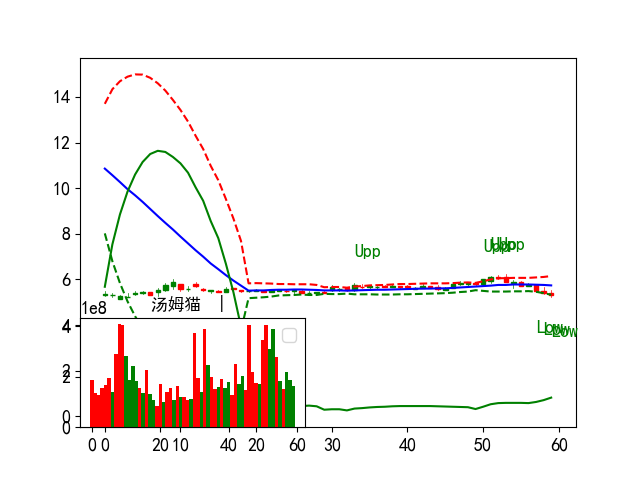

In [61]:
dfNow.loc['300459'][-2:].upper
print(dfsRoot.loc['300459'][-tail_days:].shape)
show_ohlc_upper(dfsRoot.loc['300459'][-tail_days:],code='300459')

In [62]:
# '302132' in dfsRoot.index

In [63]:
if top20_nd is not None:
    for co in top20_nd.index[:2]:
            print(co)
            # show_ohlc_upper(dfs.loc[co][-30:],co)
            if co in dfsRoot.index:
                show_ohlc_upper(dfsRoot.loc[co][-tail_days:],co)
            else:
                print(f'code:{co} not find in dfsRoot')

In [64]:
code_df = '600519'
dfNow_t2 = dfNow.groupby(level=[0]).tail(2)
# dfNow_f = dfNow_t2[ (dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) ]
idx = pd.IndexSlice
mask_df =  ((dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) )

dfNow_t2 = dfNow_t2.loc[idx[mask_df, :]]

group250 = dfNow_t2.groupby(level=[0])
dfNow_f = group250.tail(1).reset_index().set_index('code')
mask_df = (dfNow_f.date >= cct.get_today())
dfNow_f = dfNow_f.loc[idx[mask_df, :]]
dfNow_f[:2]

date   open   high    low  close        vol       amount  \
code                                                                    
688680 2025-09-04  46.00  49.78  45.91  46.84  5006787.0  241242704.0   
688429 2025-09-04  16.52  18.11  16.52  17.41  8851097.0  154226304.0   

        ra_diff   ma10    ma5  ...  perc5d  vol1d  vol2d   vol3d  vol4d  \
code                           ...                                        
688680     1.24  47.72  46.71  ...   -1.33  93.95 -13.23   -0.29   2.97   
688429     1.29  15.94  16.43  ...   10.68  53.66  -0.47  118.09 -18.61   

        vol5d  volsum5d  ma51d  xratio   idx  
code                                          
688680 -17.42      66.0  46.71   -0.13 -1.44  
688429  -5.16     147.5  16.43    0.07  1.81  

[2 rows x 32 columns]

In [65]:
# dfNow_f.shape,dfNow_f[:3],dfNow_t2.loc['600812'],df.loc['600812'][-2:]
# dfNow_f[dfNow_f.date >= cct.get_today()]
# dfNow_f.loc['000006']
# dfNow_t2.loc['000006']
# (dfNow_t2.loc[code_df].idx > dfNow_t2.loc[code_df].idx.shift(1)) 
# (dfNow_t2.loc[code_df].xratio > dfNow_t2.loc[code_df].xratio.shift(1))
# dfNow_f.loc[code_df],dfNow.loc[code_df]

### pandas multiinde drop last row

In [66]:
df.loc['000002'][-2:]

open  high   low  close          vol        amount  ra_diff
date                                                                   
2025-09-03  6.75  6.79  6.56   6.58  174594256.0  1.158963e+09     1.04
2025-09-04  6.59  6.60  6.48   6.53  153722512.0  1.005295e+09     1.03

In [67]:
dfNow.loc['000002'][-2:]

open  high   low  close          vol        amount  ra_diff  ma10  \
date                                                                            
2025-09-03  6.75  6.79  6.56   6.58  174594256.0  1.158963e+09     1.04  6.77   
2025-09-04  6.59  6.60  6.48   6.53  153722512.0  1.005295e+09     1.03  6.76   

             ma5  ma20  ...  perc5d  vol1d  vol2d  vol3d  vol4d  vol5d  \
date                    ...                                              
2025-09-03  6.73  6.63  ...   -2.37 -15.26  46.45 -28.93  -6.59 -28.80   
2025-09-04  6.69  6.63  ...   -3.55 -11.95 -15.26  46.45 -28.93  -6.59   

            volsum5d  ma51d  xratio   idx  
date                                       
2025-09-03     -33.1   6.73    0.02  0.02  
2025-09-04     -16.3   6.69    0.02 -0.03  

[2 rows x 31 columns]

# 基础处理

In [68]:
# show_tdx_data(dfs.loc['600519'][-2:])
dfs = dfNow.fillna(0)
groupd = dfs.groupby(level=[0])
single = False
dt_low = None
df_idx = None
if single:
    dfs_dtlen = groupd.tail(1)
    print("dfs tail1")
else:
    single = True
    dl = 30
    dindex = tdd.get_tdx_Exp_day_to_df(
        '999999', dl=dl, resample=resample).sort_index(ascending=False)
    dt = tdd.get_duration_price_date('999999', df=dindex)

    dt = dindex[dindex.index >= dt].index.values
    dt_low = dt[-1]
    print('dt_low:%s %s' % (dt_low,dt[0]))
    dtlen = len(dt) if len(dt) > 0 else 1
    dfs_dtlen = groupd.tail(dtlen)
    # import ipdb;ipdb.set_trace()
    dfs_dtlen[-2:]
    df_idx = get_groupby_mean_median_close(dfs_dtlen)

    # print(("dfs tail:%s dt:%s" % (dtlen, dt)))
    dfs_dtlen = get_multi_date_duration(dfs_dtlen, dt[-1])

# groupd2 = dfs.groupby(level=[0])
# dfs['ma%d'%cumdays] = groupd['close'].apply(pd.rolling_mean, cumdays)

# dfs.reset_index().groupby(['code'])['date'].transform('count')
# single = True

print("Low:%s" % (dt[-1]))
# dfs_dtlen.loc['999999'].reset_index().date
lastday_week = dfs_dtlen.loc['999999'].reset_index().date[0]
lastday_week
# dfs_dtlen[('ma%s') % (rollma[-1])][-2:]
# print(df_idx)

dt_low:2025-08-04 2025-09-04


open   high    low  close          vol        amount  \
code   date                                                                
000001 2025-09-03  11.98  12.01  11.74  11.75  136723248.0  1.619323e+09   
       2025-09-04  11.76  11.77  11.60  11.74  129530000.0  1.513957e+09   

                   ra_diff   ma10    ma5   ma20  ...  perc5d  vol1d  vol2d  \
code   date                                      ...                         
000001 2025-09-03     1.03  12.08  11.95  12.15  ...   -2.57  -8.41 -19.68   
       2025-09-04     1.03  12.04  11.88  12.12  ...   -2.81  -5.26  -8.41   

                   vol3d  vol4d  vol5d  volsum5d  ma51d  xratio   idx  
code   date                                                            
000001 2025-09-03   2.95   9.16 -11.10     -27.1  11.95   -0.02 -0.40  
       2025-09-04 -19.68   2.95   9.16     -21.2  11.88   -0.02 -0.32  

[2 rows x 31 columns]

Low:2025-08-04


Timestamp('2025-08-04 00:00:00')

In [69]:
time_s = time.time()
# rollma

def get_mask_df(dfs):
    dfs = dfs.fillna(0)
    idx = pd.IndexSlice
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[1])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) &  (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])

    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))
    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]*ma_250_l)
    #         & (dfs[('close')] < dfs[('ma%s')%(rollma[-1])]*ma_250_h)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))

    # & (dfs['mean'] > dfs['median'])
    # & (dfs['close'] > dfs['mean'])

    if len(rollma) > 1:

        mask = ((dfs[('ma%s') % (rollma[0])] > 0) & (dfs[('ma%s') % (rollma[-1])] > 0) &
                (dfs[('ma%s') % (rollma[0])] > dfs[('ma%s') % (rollma[-1])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[0])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[-1])]*ma_250_h) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']))
                )
    else:
        mask = ((dfs[('ma%s') % (rollma[0])] > 0) &
                (dfs[('close')] > dfs[('ma%s')%(rollma[0])]) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']) )
                )

    return dfs.loc[idx[mask, :]]

# mask = ((dfs[('close')] > dfs[('ma%s')%(rollma[-1])]))


df_mask = get_mask_df(dfs_dtlen)
print(df_mask.shape)
df_mask = get_multi_code_count(df_mask)
print((df_mask.couts[:5], df_mask.shape))

# import ipdb;ipdb.set_trace()
# df.sort_values(by='couts',ascending=0)
# groupd.first()[:2],groupd.last()[:2]
# groupd = df250.groupby(level=[0])
# '''
# groupd.transform(lambda x: x.iloc[-1])
# groupd.last()
# groupd.apply(lambda x: x.close > x.ma250)
# df.shape,df.sort_index(ascending=False)[:5]
# ?groupd.agg
# groupd = df.groupby(level=[0])
# groupd['close'].apply(pd.rolling_mean, 250, min_periods=1)
# ex:# Group df by df.platoon, then apply a rolling mean lambda function to df.casualties
# df.groupby('Platoon')['Casualties'].apply(lambda x:x.rolling(center=False,window=2).mean())

code_uniquelist = df_mask.index.get_level_values('code').unique()
code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]

# if app:
#     print(round(time.time() - time_s, 2), 's', df.index.get_level_values(
#         'code').unique().shape, code_select, df.loc[code_select][-1:])

if single:
    # groupd = df.groupby(level=[0])
    if tdx:
        # block_path = tdd.get_tdx_dir_blocknew() + '060.blk'
        # if cct.get_work_time():
        #     codew = df[df.date == cct.get_today()].index.tolist()

        if dt_low is not None:

            groupd2 = df_mask.groupby(level=[0])
            df_mask = groupd2.tail(1)
            df_mask = df_mask.reset_index().set_index('code')
            # import ipdb;ipdb.set_trace()

            # df = df[(df.date >= dt_low) & (df.date <= cct.get_today())]
            dd = df_mask[(df_mask.date == dt_low)]
            # df = df[(df_mask.date >= cct.last_tddate(1))]
            df_mask = df_mask[(df_mask.date >= df_mask.date.max())]
            # import ipdb;ipdb.set_trace()
            print(("dt_low:%s df:%s %s df_idx:%s" %
                  (dt_low,len(df_mask), df_mask.index[:5], len(df_idx))))


                
            print(("Main Down dd :%s MainUP df:%s couts std:%0.1f " %
                  (len(dd), len(df_mask), df_mask.couts.std())))
            # print df.date.mode()[0]
            if len(df_mask) > 0:
                if df_idx is not None and len(df_mask) > 0 and len(df_idx) > 0:
                    idx_set_ = [x for x in df_idx.index if x in df_mask.index]
                    # df_mask = df_mask.loc[idx_set_, :].dropna()
                df_mask = df_mask.sort_values(by='couts', ascending=1)
                df_mask = df_mask[df_mask.couts > df_mask.couts.std()]
            else:
                print("df_mask is None:%s"%(len(df_mask)))
            # df = df[(df.date >= df.date.mode()[0]) & (df.date <= cct.get_today())]
            codew = df_mask.index.tolist()

            if app:
                print(
                    "time: %s  %s" %
                    (round(time.time() - time_s, 2), len(df_mask)))

        else:
            df_mask = df_mask.reset_index().set_index('code')
            df_mask = df_mask[(df_mask.date >= cct.last_tddate(days=10)) &
                              (df_mask.date <= cct.get_today())]
            codew = df_mask.index.tolist()

        top_temp = tdd.get_sina_datadf_cnamedf(codew, df_mask)
  #      top_temp = top_temp[(~top_temp.index.str.contains(
  #          '688')) & (~top_temp.name.str.contains('ST'))]
        top_temp = top_temp.sort_values(by=['couts'], ascending=[0])
        codew = top_temp.index.tolist()

        # clean st and 688

    # df['date'] = df['date'].apply(lambda x:(x.replace('-','')))
    # df['date'] = df['date'].astype(int)
    # print df_mask.loc[code_select].T,df_mask.shape
#     MultiIndex = False
# else:
#     MultiIndex = True

(23454, 31)
count dd.couts
(code    date      
603713  2025-08-04    24
600021  2025-08-04    24
301369  2025-08-04    24
300308  2025-08-04    24
603713  2025-08-05    24
Name: couts, dtype: int64, (23454, 32))
dt_low:2025-08-04 df:268 Index(['603713', '600021', '301369', '300308', '605288'], dtype='object', name='code') df_idx:897
Main Down dd :0 MainUP df:268 couts std:5.9 
time: 0.06  242


In [70]:
dfs_dtlen.loc['002987'][-1:]

open   high    low  close         vol       amount  ra_diff  \
date                                                                       
2025-09-04  22.16  22.44  21.44  22.03  34616628.0  764503552.0      1.8   

             ma10    ma5  ma20  ...  perc5d  vol1d  vol2d  vol3d  vol4d  \
date                            ...                                       
2025-09-04  24.76  23.45  23.6  ...  -12.92  -20.0 -42.68  18.92  -3.67   

            vol5d  volsum5d  ma51d  xratio   idx  
date                                              
2025-09-04   3.44     -44.0  23.45    0.22 -5.17  

[1 rows x 31 columns]

## 最近60天筛选

In [71]:
# 截取最后5天数据
dfs_tail = dfs.groupby(level=[0]).tail(tail_days)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# dfs_tail[dfs_tail.ra_diff > 2]

### filter mask250 get_level_values

In [108]:
mask250 = ((dfs_tail[('ma%s') % (rollma[0])] > 0) & (dfs_tail[('ma%s') % (rollma[-1])] > 0) &
           (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[0])])
            & (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[-1])]*1.03)
              & (dfs_tail[('close')] < dfs_tail[('ma%s') % (rollma[-1])]*1.1)
                & (dfs_tail[('close')] > dfs_tail[('ma20')])
           & (dfs_tail[('close')] < dfs_tail[('ma20'   )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail.loc[idx[mask250, :]]
print(df_mask250.shape)
df_mask250 = get_multi_code_count(df_mask250)
print((df_mask250.couts[:1], df_mask250.shape))

groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1)
# df_mask250 = df_mask250[df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10] ]
# df_mask250 = clean_688(df_mask250)

# df_mask250['idx'] = df_idx_detect
print((df_mask250.couts[:2], df_mask250.shape))
# print(df_mask.loc['002987'])
df_mask250 = df_mask250.sort_values(
        by=['ra_diff','hat', 'couts'],
        ascending=[0,0, 0])
show_tdx_data(df_mask250)[:5]

(1391, 31)
count dd.couts
(code    date      
002983  2025-07-25    20
Name: couts, dtype: int64, (1391, 32))
(code    date      
002983  2025-08-26    20
600235  2025-08-26    18
Name: couts, dtype: int64, (370, 32))
Count:370 32


couts  ra_diff  xratio   idx    hat  close  volsum5d  \
code   date                                                               
603226 2025-08-22      1     3.00    0.00  0.00   7.08  22.39       6.4   
300528 2025-07-31      1     2.55    0.00  0.00  19.02  23.22     584.5   
688265 2025-08-29      2     2.34    1.28 -8.79  35.07  62.09     102.8   
600326 2025-08-19      1     2.31    0.00  0.00   9.59  16.59      42.2   
002826 2025-08-19      1     2.09    0.00  0.00   6.42  24.39      54.4   

                    hmax   lmin  perc1d   ma20  ma250  vol1d  vol2d   vol3d  \
code   date                                                                   
603226 2025-08-22  23.34  16.50    0.77  20.96  20.50 -33.04  -4.10   -0.39   
300528 2025-07-31  28.27   9.82   -8.26  22.77  22.42  38.86   2.72  209.04   
688265 2025-08-29  72.75  36.00    3.28  56.54  57.91  -8.87 -37.56  127.18   
600326 2025-08-19  19.50   8.98   -2.70  15.52  15.22 -11.94  14.06  -23.07   
002826 2025-08-19  25.41  17.88    0.12  24.28  22.53   6.47  -9.69  -31.51   

                    vol4d   vol5d  perc3d  perc5d  
code   date                                        
603226 2025-08-22  -39.07   83.04    2.14   -0.27  
300528 2025-07-31  -72.45  406.29   32.08   -1.07  
688265 2025-08-29  -14.21   36.22    8.28    4.25  
600326 2025-08-19   81.23  -18.12    1.10    5.07  
002826 2025-08-19  128.99  -39.87    3.79    6.04

#### filter today

In [73]:
df_mask250  = df_mask250[(df_mask250.xratio > 0) & (df_mask250.index.get_level_values('date') > cct.get_today() )]
# df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape


In [74]:
# df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10]

#### debug ra_diff4

In [75]:
dfs.loc['301073'][-5:].ra_diff

date
2025-08-29    1.21
2025-09-01    1.25
2025-09-02    1.24
2025-09-03    1.20
2025-09-04    1.22
Name: ra_diff, dtype: float64

xratio:0.0 ra_diff:1.03
code: 000002


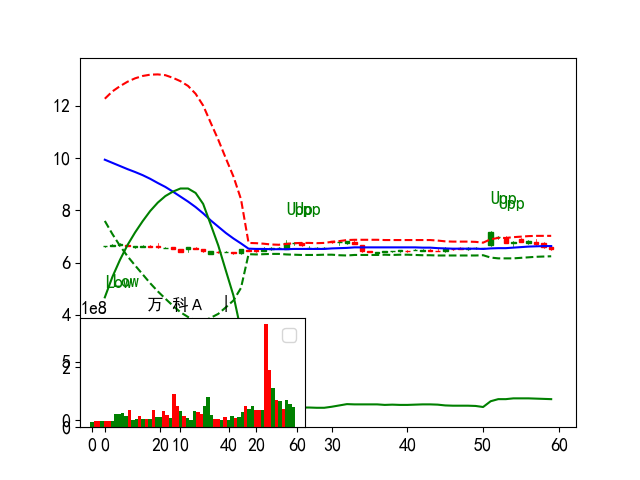

In [76]:
# dfs.loc['000002'][-60:]
show_ohlc_upper(dfsRoot.loc['000002'][-60:],code='000002')
for co in df_mask250.index.get_level_values(0)[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-tail_days:],code=co)

## 最近60天数据

In [77]:
dfs_tail9 = dfs.groupby(level=[0]).tail(tail_days)

# 提取倒数第二天
# dfs_tail9 = dfs.groupby(level=[0]).tail(6)
# dfs_tail9 = dfs_tail9[dfs_tail9.index.get_level_values(1) <lastday]


# dfs_tail9.index.get_level_values(0)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# print(dfs_tail9.loc['002987'][:1])
# show_tdx_data(dfs_tail9.loc[code_t])
# dfs_tail9=compute_perd_value(dfs_tail9,market_value=5,col='vol')

# show_tdx_data(dfs_tail9.loc[code_t])
# print((dfs_tail9.loc[code_t]))

In [78]:
dfs_tail9.loc[(['999999','399001','399006'],'ra_diff')].groupby(level=0).tail(3)
# dfs_tail9.loc[pd.IndexSlice[['999999','399001','399006'], :, :]].tail(3)
# dfs_tail9.query(("code == '999999'" and "date > '2023-04-01'"))

code    date      
999999  2025-09-02    1.16
        2025-09-03    1.14
        2025-09-04    1.13
399001  2025-09-02    1.25
        2025-09-03    1.24
        2025-09-04    1.21
399006  2025-09-02    1.44
        2025-09-03    1.46
        2025-09-04    1.39
Name: ra_diff, dtype: float64

## 超跌反弹年线大于MA20

In [ ]:
# show_tdx_data(dfs_tail9.loc['300418'])[-2:]
show_tdx_data(dfs_tail9.loc['603131'])
# print(dfs_tail9.loc['603131',['high','upper','hmax']])

Count:30 31


ra_diff  xratio  idx   hat  close  volsum5d   hmax   lmin  perc1d  \
date                                                                            
2025-08-15     1.20     0.0  0.0  5.87  20.02     -75.9  22.56  17.19    1.62   
2025-08-18     1.21     0.0  0.0  5.85  20.06     -96.2  22.56  17.19    0.20   
2025-08-19     1.25     0.0  0.0  5.78  20.70       4.6  22.56  17.28    3.19   
2025-08-20     1.26     0.0  0.0  5.71  20.91      14.1  22.56  17.31    1.01   
2025-08-21     1.22     0.0  0.0  5.43  20.23     -32.2  22.56  17.70   -3.25   

             ma20  ma250  vol1d  vol2d  vol3d  vol4d  vol5d  perc3d  perc5d  
date                                                                         
2025-08-15  18.21  13.43 -29.65   4.68 -23.91 -40.72  13.65   -4.26   -7.40  
2025-08-18  18.52  13.45  -6.61 -29.65   4.68 -23.91 -40.72   -2.53  -10.37  
2025-08-19  18.87  13.47  60.12  -6.61 -29.65   4.68 -23.91    5.08   -1.00  
2025-08-20  19.23  13.50 -14.43  60.12  -6.61 -29.65   4.68    4.45    1.60  
2025-08-21  19.56  13.51 -41.64 -14.43  60.12  -6.61 -29.65    0.85    2.69

## !!! Run-Filter强势Upper

### !!! filterRule test

In [80]:
# dfs_tail9.loc['002722']


def rules_to_list(rules):
    rules_l = (rules).split('&')
    for l in rules_l:
        print(l)
    return rules_l


def filter_rule_Test(dfs_tail9,resample=resample):
    col_rule = ["(dfs_tail9[('close')] > dfs_tail9[('ma5')])",
                "(dfs_tail9[('high')] > dfs_tail9.upper)",
                "(dfs_tail9[('ma5')] > dfs_tail9[('ma20')])"]
    col_rule2 = [
        "(dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(1)*0.98) | (dfs_tail9['close'] > dfs_tail9['hmax']*0.97)",
        "((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))"]
    col_rule3 = [
        "((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))"]

    col_rule_tail1 = ["(dfs_tail9.perc1d < 21)", "(dfs_tail9.perc2d > 0)"]
    if resample.upper()=='D':
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9[('close')] > dfs_tail9[('ma250')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])",
                 "(dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99)"]
    else:
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])"]
    col_rule_tail4=[ "(dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))",
             "(dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))"]
    
    col_rule.extend(col_rule2)
    col_rule.extend(col_rule3)
    col_rule.extend(col_rule_tail1)
    col_rule.extend(col_rule_tail2)
    col_rule.extend(col_rule_tail3)
    col_rule.extend(col_rule_tail4)
    
    for co in col_rule:
        print("%s:%s" % (co, eval(co)), end='')



30
9 -0.02 -0.2


'Bear'

-0.2

date
2025-08-29    0.01
2025-09-01    0.01
2025-09-02    0.01
2025-09-03    0.01
2025-09-04    0.01
Name: xratio, dtype: float64

xratio:-0.01 ra_diff:1.01
code: 601728


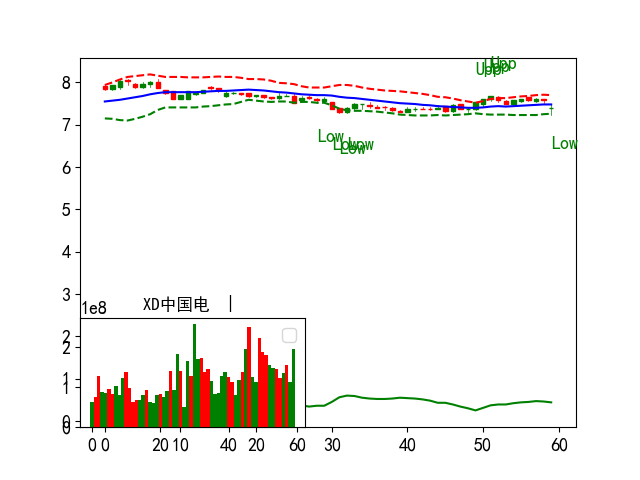

In [81]:
code_filter = '601728'

print(len(dfs_tail9.loc[code_filter]))

# show_tdx_data(dfs_tail9.loc[code_filter])
detect_bull_bear(dfs.loc[code_filter][-120:].close)
detect_bull_bear_apply(dfs.loc[code_filter][-120:].close)

dfs.loc[code_filter].xratio[-5:]

# filter_rule_Test(dfs_tail9.loc[code_filter])

show_ohlc_upper(dfsRoot.loc[code_filter][-60:], code=code_filter)



In [82]:
# dfs.loc['300474'][-5:]

### 新高Hmax日见新高df_mask_hmax

#### hmax 追高 TEST

30
xratio:-0.06 ra_diff:1.0
code: 600012


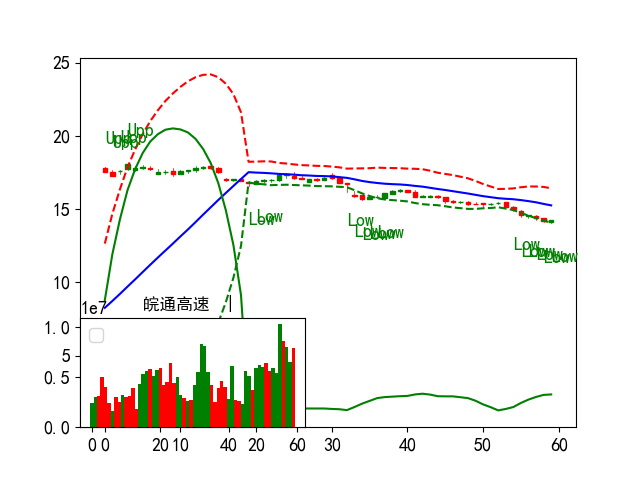

In [83]:
code='600012'
print(len(dfs_tail9.loc[code]))
# show_tdx_data(dfs_tail9.loc[code],col='upper')
show_ohlc_upper(dfsRoot.loc[code],code=code)

In [ ]:

# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ((dfs_tail9[('hmax')] > 0) &

if resample.upper() =='D':
    mask_hmax = ( (dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(1)) &
                 ((dfs_tail9[('high')] >= dfs_tail9[('hmax')])) &
                 (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99))
                 # (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99) &
                 # (dfs_tail9[('close')] < dfs_tail9.ma250 * 1.05))
else:
    mask_hmax = ( (dfs_tail9[('low')] >= dfs_tail9[('ma5')].shift(1))  &
              (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1))  ) 

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & (dfs_tail9[('close')] > dfs_tail9.ma20 *0.99) & (dfs_tail9[('close')] < dfs_tail9.ma20 *1.20) )


df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]
df_mask_hmax = get_multi_code_count(df_mask_hmax)

# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

# df_mask_hmax.couts.std()

df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')

df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts','volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0,0, 0, 0, 0])
    # by=['volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0, 0, 0, 0])
# print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['300461'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
show_tdx_data(df_mask_hmax)
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)]).T

count dd.couts
compute percent


(code
 600021    19
 Name: couts, dtype: int64,
 (94, 40))

Count:94 40


name  couts       date   perc  ra_diff  xratio    idx     hat   close  \
code                                                                            
600021  上海电力     19 2025-09-04  -1.82     2.15    0.39   5.12   10.95   18.88   
300308  中际旭创     17 2025-09-04 -13.37     4.09    9.29  90.25  263.54  369.25   
600673   东阳光     16 2025-09-04  -9.95     2.48    0.47   4.54   12.82   23.52   
601869  长飞光纤     14 2025-09-04  -5.56     2.69    1.77  27.03   58.15   86.00   
601877  正泰电器     14 2025-09-04  -1.70     1.27    0.24   3.39    7.01   27.72   
300709  精研科技     13 2025-09-04   1.06     1.54    0.49   6.31   13.89   56.00   
300724  捷佳伟创     13 2025-09-04 -10.32     1.98    2.00  23.62   62.58  101.00   
002975  博杰股份     12 2025-09-04  -1.72     1.97    0.56  15.94   21.93   62.78   
300450  先导智能     12 2025-09-04   1.98     2.25    0.73  15.75   26.23   44.84   
300620  光库科技     12 2025-09-04 -11.58     2.37    2.57   4.69   61.15   93.50   

        volsum5d  ...    ma20  ma250    llow  vol1d    vol2d  vol3d  vol4d  \
code              ...                                                        
600021     389.2  ...   13.91   6.88   18.30 -22.36   526.77 -56.33 -45.67   
300308      59.7  ...  299.26  53.99  364.00  31.82    -9.15  30.98  22.09   
600673      40.3  ...   19.55   9.77   23.52 -20.36    11.27 -25.17  38.30   
601869     303.9  ...   67.94  21.75   81.94  45.39   -22.21 -21.93  89.53   
601877     -53.4  ...   25.25  13.72   27.34 -13.35    26.07 -36.21  -5.01   
300709      96.0  ...   50.61  27.44   54.50  38.89   -11.81  -8.39  28.10   
300724      42.6  ...   83.76  42.09   98.88  64.01   -19.87  24.67  13.86   
002975    1083.5  ...   49.99  34.42   60.62  11.42  1158.77 -48.76 -20.49   
300450     194.8  ...   31.28  17.95   43.06   5.80   -13.99  -3.76  88.74   
300620       7.6  ...   88.04  35.12   91.00  14.62   -16.34   3.20  40.96   

         vol5d  perc3d  perc5d  
code                            
600021  -13.19   12.11   28.26  
300308  -16.03   -9.05    2.86  
600673   36.24   -2.77   15.07  
601869  213.17   -6.52    3.69  
601877  -24.94   -0.68   -0.50  
300709   49.20   -2.98   10.15  
300724  -40.05   -6.59    2.28  
002975  -17.41   18.88   31.56  
300450  118.01   10.20   51.54  
300620  -34.86  -15.43   -7.43  

[10 rows x 23 columns]

#### !!! hmax Top upper > 1

In [85]:
# dfs_tail9.loc['600103']

In [86]:
# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) ) )
# mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) )
if resample.upper() == 'D':
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )
else:
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )

df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]

#站上Upper
# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

df_mask_hmax = get_multi_code_count(df_mask_hmax)
df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')



df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts', 'idx', 'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
 # by=['volsum5d', 'idx', 'hat', 'perc1d'],
print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['000039'])
df_mask_hmax.couts[:1], df_mask_hmax.shape

# show_tdx_data(df_mask_hmax).T
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)])
show_tdx_data(df_mask_hmax.query('couts >= 1 and perc >2  and   low < ma5 '),limit=10 )

count dd.couts
compute percent
code
603099    10
Name: couts, dtype: int64 (95, 40)


(code
 603099    10
 Name: couts, dtype: int64,
 (95, 40))

Count:40 40


name  couts       date   perc  ra_diff  xratio   idx   hat  close  \
code                                                                        
601288  农业银行      9 2025-09-04   5.17     1.37    0.03  0.22  0.84   7.52   
000524  岭南控股      8 2025-09-04  10.00     1.38    0.11  2.63  3.10  15.73   
002691  冀凯股份      7 2025-09-04   2.09     1.25    0.04  1.20  1.55   9.78   
002426  胜利精密      6 2025-09-04  10.09     1.41    0.03  0.44  0.85   3.82   
603630  拉芳家化      5 2025-09-04  10.06     1.57    0.22  6.64  7.95  31.19   
600593  大连圣亚      5 2025-09-04   7.37     1.37    0.24  6.50  8.14  39.19   
603595  东尼电子      4 2025-09-04   9.99     1.44    0.25  5.98  8.64  25.98   
300035  中科电气      4 2025-09-04   2.92     1.62    0.22  4.27  6.63  22.55   
003006  百亚股份      4 2025-09-04   5.10     1.27    0.19  3.09  4.97  31.73   
002709  天赐材料      4 2025-09-04   6.19     1.38    0.14  2.75  3.84  23.16   

        volsum5d  ...   ma20  ma250   llow   vol1d  vol2d   vol3d  vol4d  \
code              ...                                                      
601288      95.9  ...   7.05  19.92   7.05  111.56 -20.34   24.28   2.89   
000524     108.8  ...  13.27  19.33  14.12   43.14   6.67   38.70  19.79   
002691      66.4  ...   8.82   6.80   9.16    3.33  12.39   65.44 -17.34   
002426      82.8  ...   3.39  10.17   3.50   39.08   6.13  -34.95  99.46   
603630      67.0  ...  25.18  14.45  27.50   22.27 -27.14  106.76 -21.09   
600593      97.2  ...  33.31  12.25  35.31   26.58  42.37  -21.62   5.35   
603595      89.3  ...  20.89  24.50  23.06   49.98  -9.68  -43.26  44.75   
300035     270.8  ...  18.91  18.44  21.34   28.05  69.85  -35.13 -22.92   
003006      43.3  ...  29.28  34.28  29.80   43.61  31.36  -53.54   8.20   
002709     172.0  ...  20.68  19.03  21.95  106.64  -5.64   -4.48 -16.28   

         vol5d  perc3d  perc5d  
code                            
601288  -22.49    6.67    7.12  
000524    0.51   13.08   17.92  
002691    2.60   11.26   10.88  
002426  -26.92    2.96    7.30  
603630  -13.82   15.65   24.07  
600593   44.56   10.12   18.65  
603595   47.47    6.65   22.37  
300035  230.96    5.32   21.89  
003006   13.66    5.35    8.70  
002709   91.73    5.80   13.09  

[10 rows x 23 columns]

In [87]:
# show_tdx_data(df_mask_hmax.loc['600103'][-5:])

##### sort_values

In [88]:
show_tdx_data(
    df_mask_hmax.query('perc > 1').sort_values(
        by=['ra_diff', 'couts', 'idx'],
        ascending=[0, 0, 0]),col='ra_diff')

Count:81 40


name  couts       date   perc  ra_diff  ra_diff  xratio    idx    hat  \
code                                                                            
300450  先导智能      8 2025-09-04   1.98     2.25     2.25    0.73  15.75  26.23   
605580  恒盛能源      9 2025-09-04   1.58     2.01     2.01    0.21   3.96   6.07   
603848   好太太      9 2025-09-04   2.77     1.95     1.95    0.38   3.09   8.56   
603090  宏盛股份      5 2025-09-04   6.98     1.81     1.81    0.29   9.44  10.91   
603099   长白山     10 2025-09-04   8.68     1.76     1.76    0.58  13.88  19.03   
002846  英联股份      6 2025-09-04   1.57     1.74     1.74    0.11   2.97   5.63   
002759  天际股份      3 2025-09-04  10.02     1.69     1.69    0.10   2.72   3.33   
600826  兰生股份      3 2025-09-04   3.30     1.69     1.69    0.06   1.61   2.16   
600330  天通股份      8 2025-09-04   3.77     1.66     1.66    0.11   2.16   3.47   
603903  中持股份      7 2025-09-04   2.59     1.63     1.63    0.14   3.18   4.78   
300035  中科电气      4 2025-09-04   2.92     1.62     1.62    0.22   4.27   6.63   
002882   金龙羽      3 2025-09-04  10.01     1.59     1.59    0.13   5.13   6.15   
300014  亿纬锂能      6 2025-09-04   4.50     1.58     1.58    0.80  18.38  25.10   
603630  拉芳家化      5 2025-09-04  10.06     1.57     1.57    0.22   6.64   7.95   
301257   普蕊斯      2 2025-09-04   1.35     1.56     1.56    0.21   8.00  13.67   
002263   大东南      2 2025-09-04   4.97     1.56     1.56    0.01   0.35   0.65   
600250  南京商旅      2 2025-09-04   1.76     1.54     1.54    0.06   1.29   2.16   
601069  西部黄金      4 2025-09-04   2.22     1.53     1.53    0.18   8.25  10.02   
300827  上能电气      2 2025-09-04  13.32     1.53     1.53    0.21   9.53   9.79   
002121  科陆电子      1 2025-09-04   8.26     1.53     1.53    0.01   0.27   0.73   

        close  ...   ma20  ma250   llow   vol1d   vol2d   vol3d   vol4d  \
code           ...                                                        
300450  44.84  ...  31.28  17.95  43.06    5.80  -13.99   -3.76   88.74   
605580  21.84  ...  18.89  29.12  20.73   38.69   38.17  -27.03  -22.36   
603848  27.78  ...  23.31  18.54  26.61  -20.03   67.86   60.95  -11.63   
603090  41.69  ...  34.68  21.55  38.97   22.08  -18.08   54.73   28.56   
603099  55.97  ...  42.85  27.36  50.09   34.70   19.45   -1.72    4.14   
002846  19.38  ...  16.82  33.30  18.69    0.63  165.31  -45.89   32.41   
002759  12.63  ...  10.24  11.08  11.92  -42.29   60.18  -37.55   18.65   
600826  12.82  ...  11.41   8.02  12.00    7.98   63.47  -34.00   10.77   
600330  11.00  ...   9.05  12.00  10.93   50.41   38.80   -2.11   -5.85   
603903  11.90  ...   9.28  14.43  11.23   -6.68   16.53   21.12   37.23   
300035  22.55  ...  18.91  18.44  21.34   28.05   69.85  -35.13  -22.92   
002882  37.16  ...  32.72  18.75  33.81  105.79  -33.34   26.19   44.41   
300014  66.88  ...  51.14  19.58  65.25   12.76   87.99    8.44  -34.14   
603630  31.19  ...  25.18  14.45  27.50   22.27  -27.14  106.76  -21.09   
301257  46.50  ...  40.46  36.89  45.31   39.53  -28.95  -36.36   95.72   
002263   4.01  ...   3.64  11.40   3.77    0.98   13.76   74.99  183.74   
600250  13.32  ...  11.92   6.51  12.53   12.75   27.37  100.32  -19.85   
601069  27.11  ...  20.44  13.73  25.61    7.75   74.67   39.59  -21.89   
300827  34.12  ...  25.29  17.90  31.00   34.95   86.58  164.21  -41.18   
002121   7.34  ...   7.01  10.60   6.90  183.84   72.15   23.99  -12.88   

         vol5d  perc3d  perc5d  
code                            
300450  118.01   10.20   51.54  
605580   53.64    4.15   12.69  
603848  -37.26   16.19   14.42  
603090    1.83   15.42   22.83  
603099   17.48   17.14   30.25  
002846  144.86    5.84   23.52  
002759  123.67   11.67   25.05  
600826  -27.12    5.25    7.19  
600330   82.56    9.45   21.28  
603903  -54.91   14.53   20.45  
300035  230.96    5.32   21.89  
002882   17.74    8.69   20.10  
300014   51.45   19.69   24.94  
603630  -13.82   15.65   24.07  
301257  165.22   -1.65   28.17  
002263  -42.1

xratio:-0.04 ra_diff:1.1
code: 300540


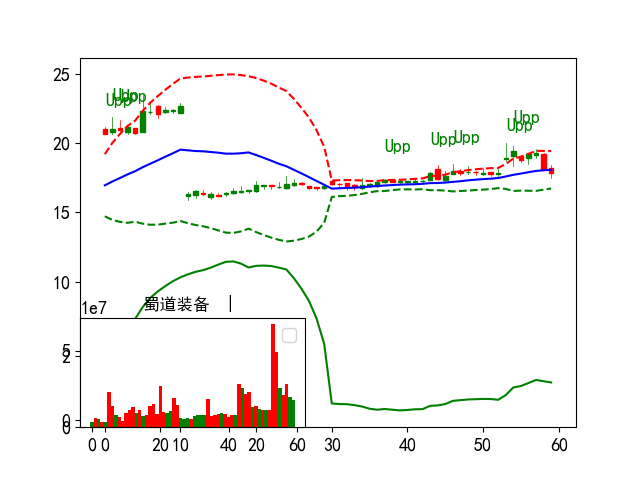

In [89]:
show_ohlc_upper(dfsRoot.loc['300540'][-60:],code='300540')

### !!! df_mask250 upper xratio 加速

In [90]:

if resample.upper() =='D':
    mask250 = ((dfs_tail9[('high')] > dfs_tail9.upper) &
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift( 1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['close'] > dfs_tail9[('hmax')]) &
                (dfs_tail9[('close')] > dfs_tail9[('ma250')]) | ((dfs_tail9[('high')] > dfs_tail9.upper) &
                                                                 (dfs_tail9[('close')] > dfs_tail9[('ma5')])) &
               (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('close')] > dfs_tail9[('ma250')])
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
elif resample.upper() =='W' or resample == 'W-FRI':
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
else:
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
              )

# & (dfs_tail9[('close')] < dfs_tail9[('ma20'  )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail9.loc[idx[mask250, :]]
df_mask250.shape
#站上Upper
df_mask250 = df_mask250[ (df_mask250[('close')] > df_mask250.upper)]

df_mask250 = get_multi_code_count(df_mask250)


code_t = '603131'
print((df_mask250.couts[:3], df_mask250.shape))
# df_mask250.loc[code_t]
groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1).reset_index().set_index('code')
# df_mask250 = get_sina_data_cname(df_mask250, dm,realtime=True)



# df_mask250.loc[code_t].close
df_mask250 = get_sina_data_cname(df_mask250, realtime=True)
# df_mask250.loc[code_t].close

df_mask250 = clean_688(df_mask250)
# df_masklastd.loc['002722']

df_mask250 = df_mask250.sort_values(
    by=['idx','xratio',  'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
    # by=['xratio', 'idx', 'hat', 'perc1d'],

# by=['perc', 'perc5d', 'perc1d'],
# ascending=[0, 0, 0])
print("df_mask250:%s df_mask_hmax:%s"%(len(df_mask250),len(df_mask_hmax)))
cross_hmax_250 = [co for co in df_mask250.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_mask250.loc[cross_hmax_250].query('couts > 1 and perc > 0'))
# show_tdx_data(df_mask250.query('couts > 1 and perc > 0')[:20])
# show_tdx_data(df_mask250.loc[code_t])

(862, 31)

count dd.couts
(code    date      
605255  2025-08-27    6
        2025-08-28    6
        2025-08-29    6
Name: couts, dtype: int64, (613, 32))
compute percent
df_mask250:299 df_mask_hmax:95
cross_hamx:32
Count:13 40


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                          
300014  亿纬锂能      4 2025-09-04   4.50     1.58    0.80  18.38  25.10  66.88   
300450  先导智能      4 2025-09-03   1.98     2.21    0.62  16.45  23.28  44.84   
603099   长白山      5 2025-09-04   8.68     1.76    0.58  13.88  19.03  55.97   
605117  德业股份      2 2025-09-04   2.71     1.34    0.70  10.19  18.84  68.69   
601069  西部黄金      4 2025-09-04   2.22     1.53    0.18   8.25  10.02  27.11   
300919  中伟股份      2 2025-09-04  11.20     1.39    0.24   7.68   8.28  43.09   
600593  大连圣亚      4 2025-09-04   7.37     1.37    0.24   6.50   8.14  39.19   
603595  东尼电子      2 2025-09-04   9.99     1.44    0.25   5.98   8.64  25.98   
300035  中科电气      3 2025-09-04   2.92     1.62    0.22   4.27   6.63  22.55   
603630  拉芳家化      2 2025-09-03  10.06     1.43    0.17   3.39   5.60  31.19   
002759  天际股份      2 2025-09-02  10.02     1.50    0.08   1.40   2.31  12.63   
002882   金龙羽      2 2025-09-02  10.01     1.49    0.08   1.34   4.39  37.16   
600250  南京商旅      2 2025-09-04   1.76     1.54    0.06   1.29   2.16  13.32   

        volsum5d  ...   ma20  ma250   llow  vol1d   vol2d   vol3d   vol4d  \
code              ...                                                       
300014     126.5  ...  51.14  19.58  65.25  12.76   87.99    8.44  -34.14   
300450     187.4  ...  30.33  18.18  43.09 -13.99   -3.76   88.74  118.01   
603099      74.1  ...  42.85  27.36  50.09  34.70   19.45   -1.72    4.14   
605117      79.3  ...  59.22  43.48  67.56  19.46   48.45   13.34  -26.40   
601069     227.9  ...  20.44  13.73  25.61   7.75   74.67   39.59  -21.89   
300919     217.4  ...  36.12  33.74  38.59  94.90   54.56   -9.27  -23.04   
600593      97.2  ...  33.31  12.25  35.31  26.58   42.37  -21.62    5.35   
603595      89.3  ...  20.89  24.50  23.06  49.98   -9.68  -43.26   44.75   
300035     270.8  ...  18.91  18.44  21.34  28.05   69.85  -35.13  -22.92   
603630     104.7  ...  24.84  14.40  27.55 -27.14  106.76  -21.09  -13.82   
002759     114.3  ...   9.96  11.04  10.99 -37.55   18.65  123.67  -16.89   
002882      87.4  ...  32.37  18.64  33.78  26.19   44.41   17.74   14.75   
600250     172.8  ...  11.92   6.51  12.53  12.75   27.37  100.32  -19.85   

         vol5d  perc3d  perc5d  
code                            
300014   51.45   19.69   24.94  
300450   -1.64   23.86   51.52  
603099   17.48   17.14   30.25  
605117   24.41    7.75   10.45  
601069  127.82   23.73   42.24  
300919  100.27   13.66   19.16  
600593   44.56   10.12   18.65  
603595   47.47    6.65   22.37  
300035  230.96    5.32   21.89  
603630   59.94   15.58   19.08  
002759   26.42   11.19   10.21  
002882  -15.72   12.31    4.51  
600250   52.21   10.54   13.55  

[13 rows x 23 columns]

df_mask250:27
300014 1.58
xratio:0.18 ra_diff:1.58
code: 300014


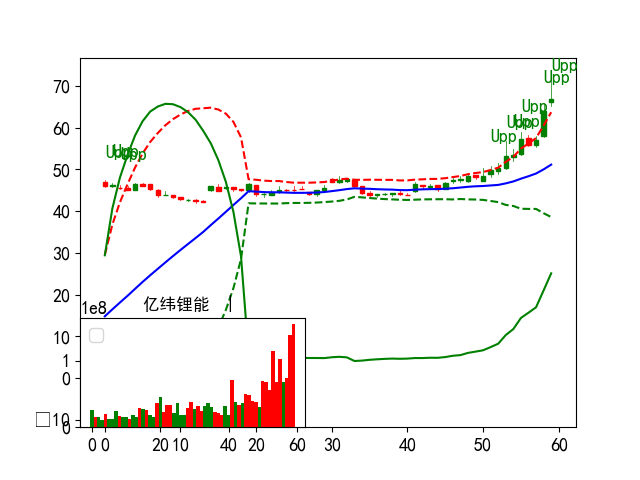

300450 2.25
xratio:0.25 ra_diff:2.25
code: 300450


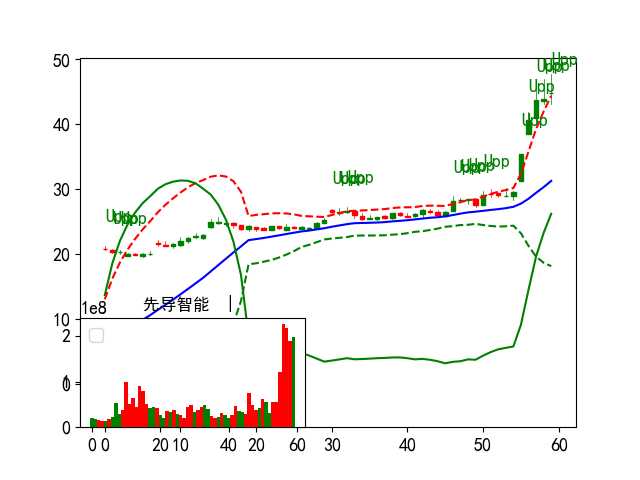

601127 1.17
xratio:0.01 ra_diff:1.17
code: 601127


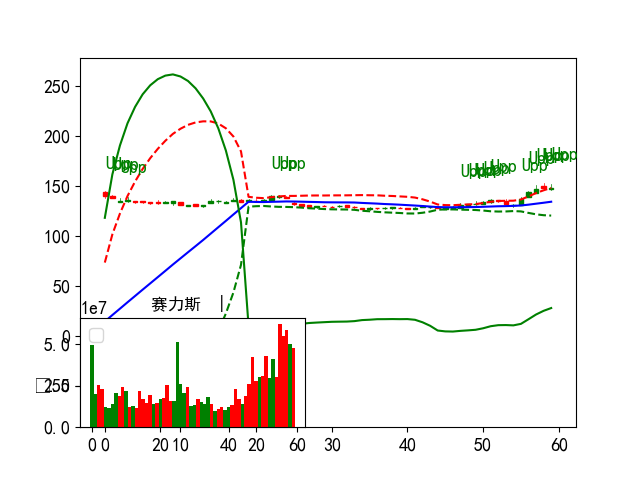

300955 1.86
xratio:0.15 ra_diff:1.86
code: 300955


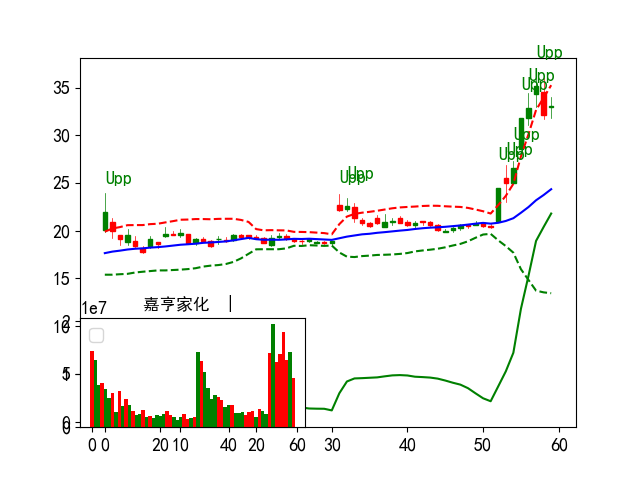

603099 1.76
xratio:0.18 ra_diff:1.76
code: 603099


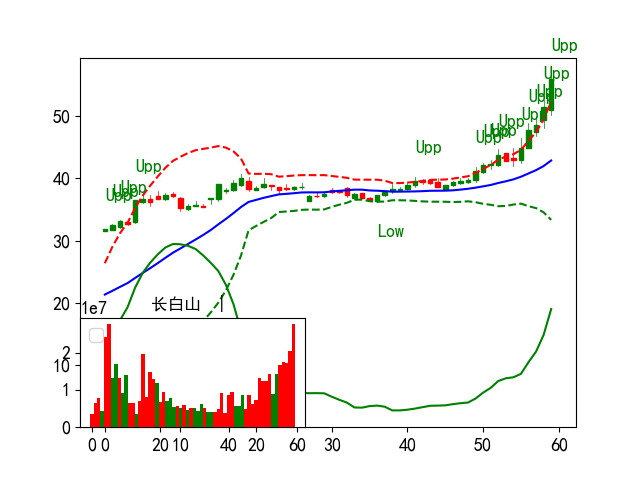

605117 1.34
xratio:-0.27 ra_diff:1.34
code: 605117


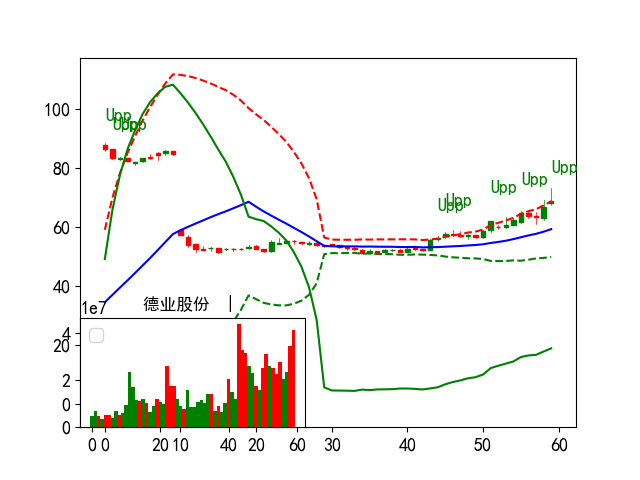

601069 1.53
xratio:0.02 ra_diff:1.53
code: 601069


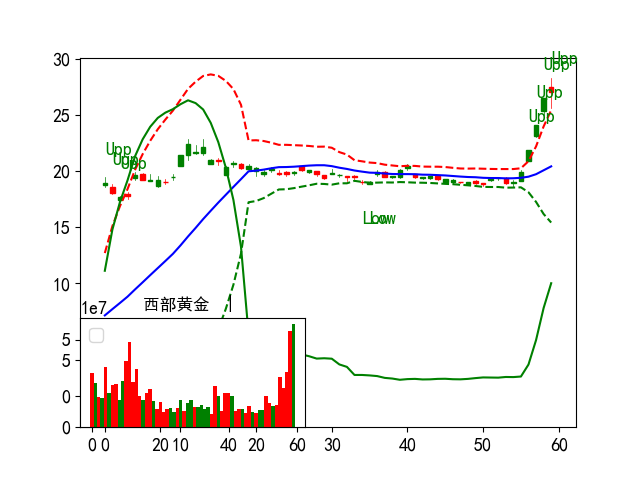

300919 1.39
xratio:0.11 ra_diff:1.39
code: 300919


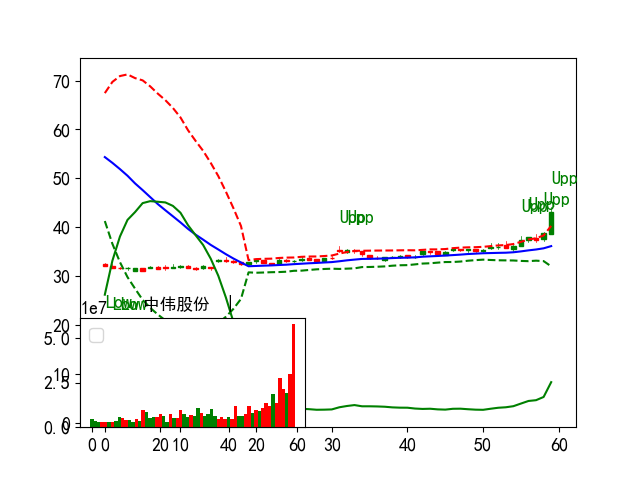

003043 1.22
xratio:-0.03 ra_diff:1.22
code: 003043


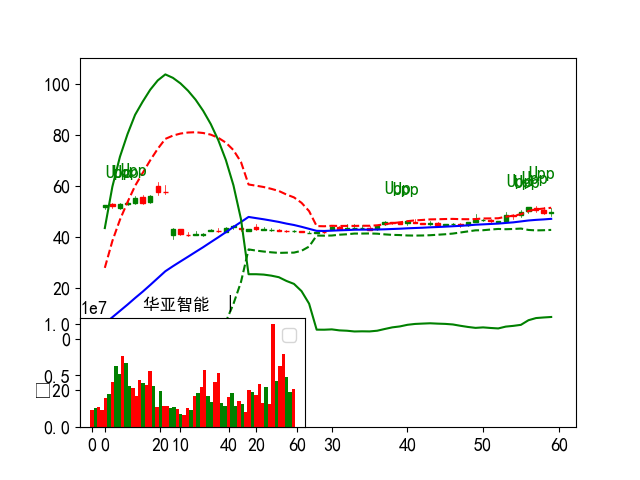

600593 1.37
xratio:0.1 ra_diff:1.37
code: 600593


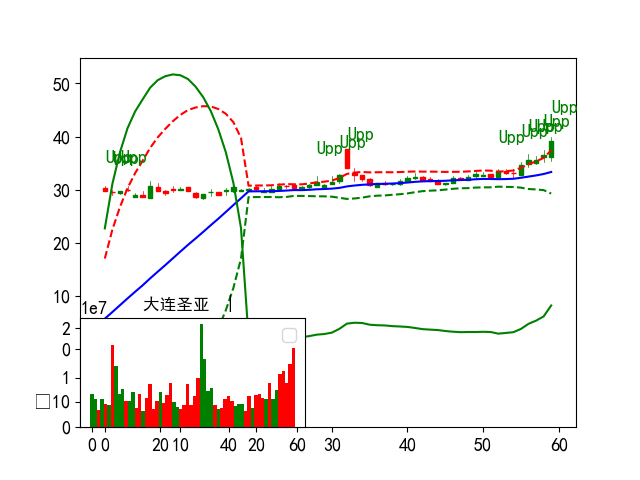

In [91]:
print("df_mask250:%s"%(len(df_mask250.query('couts > 1 and perc > 0'))))
for co in df_mask250.query('couts > 1 and perc > 0').index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Tail1 Show Top 主升浪df_masklastd

In [92]:
df_mask250[(df_mask250.date >= lastday_week)][:2]
df_mask250[df_mask250.ra_diff > 1.3].shape

date  lopen  lhigh   llow   close         vol        amount  \
code                                                                       
300308 2025-09-03  392.0  430.0  379.0  369.25  71235176.0  2.871663e+10   
300502 2025-09-01  362.0  400.0  352.0  312.00  66046192.0  2.472372e+10   

        ra_diff    ma10     ma5  ...  xratio     idx  couts  name   open  \
code                             ...                                       
300308     4.73  343.35  386.05  ...    9.10  161.00      2  中际旭创  436.0   
300502     4.46  302.94  338.00  ...    8.15  131.75      3   新易盛  383.0   

          high    low  llastp            ticktime   perc  
code                                                      
300308  448.00  364.0  426.25 2025-09-04 15:35:15 -13.37  
300502  393.75  309.0  369.75 2025-09-04 15:35:30 -15.62  

[2 rows x 40 columns]

(208, 40)

In [93]:
# df_masklastd = df_mask250[(df_mask250.date >= '2023-02-06') & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0) &
if resample.upper() =='D':
    df_masklastd = df_mask250[(df_mask250.date >= lastday) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 10) & (df_mask250.close > df_mask250.ma5) )
                          ]
                          # & ((df_mask250.perc3d > 0) | ((df_mask250.close.shift(2) > df_mask250.ma5.shift(2))) )
else:
    df_masklastd = df_mask250[(df_mask250.date >= lastday_week) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 20) & (df_mask250.close > df_mask250.ma5) )
                          ]
# (df_mask250.couts == 1) & (df_mask250.perc1d < 21)]

#当下大于上轨
df_masklastd = df_masklastd[df_masklastd.close > df_masklastd.ma5]

print("src:%s  lastd:%s " % (df_mask250.shape, df_masklastd.shape))


if resample.upper() =='M':
    df_masklastd = df_masklastd.sort_values(
        by=['perc1d', 'perc3d'],
        ascending=[0, 0])
else:
    df_masklastd = df_masklastd.sort_values(
        by=['perc3d', 'perc1d'],
        ascending=[0, 0])

# print(
#     (df_masklastd.loc
#      [:, ['name', 'couts', 'date', 'perc1d', 'perc3d', 'perc5d']][:10],
#      df_masklastd.shape,))

# show_tdx_data(df_masklastd)
print(df_masklastd.name.T[:20])
# show_tdx_data(df_masklastd[-10:])
if df_masklastd is not None and len(df_masklastd) > 0:

    code_t = '300675'
    code_t = '605268'
    code_t = '002828'
    code_t = '300418'
    code_t = df_masklastd.index[0]


# df_masklastd.loc[code_t, ['name', 'couts',
#                           'date', 'perc1d', 'perc3d', 'perc5d']]

# df_masklastd.loc[code_t].date


# df_mask250 = groupd250.head(1)

# df_masklastd.loc[code_t].date
# show_tdx_data(df_masklastd.loc[code_t])


# show_tdx_data(df_masklastd.loc[code_t])

src:(299, 40)  lastd:(22, 40) 
code
300827    上能电气
601069    西部黄金
002150    通润装备
300014    亿纬锂能
002975    博杰股份
603099     长白山
300274    阳光电源
603848     好太太
300919    中伟股份
600721    百花医药
600250    南京商旅
600593    大连圣亚
605117    德业股份
300763    锦浪科技
603595    东尼电子
603939    益丰药房
002487    大金重工
300035    中科电气
600826    兰生股份
603806     福斯特
Name: name, dtype: object


### !!! df_mask_hmax 061

df_mask_hmax:95
603099 1.76
xratio:0.18 ra_diff:1.76
code: 603099


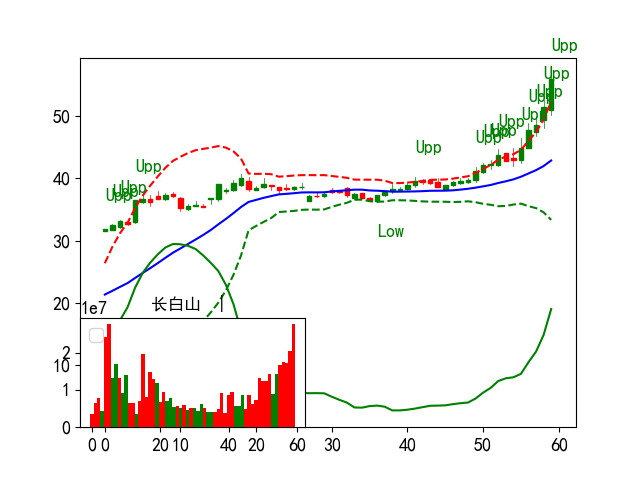

002975 1.97
xratio:0.43 ra_diff:1.97
code: 002975


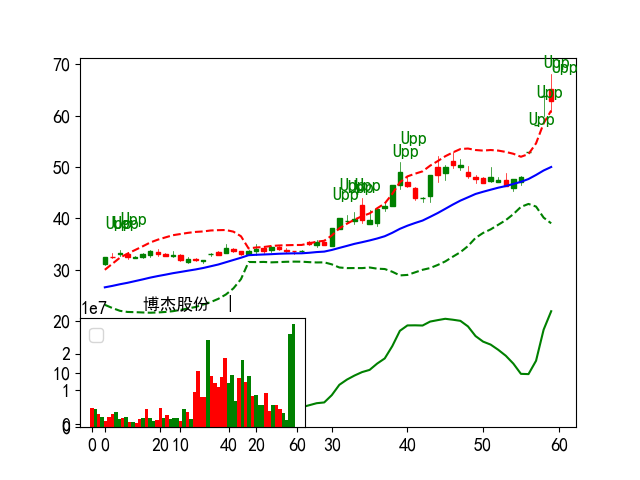

605580 2.01
xratio:0.17 ra_diff:2.01
code: 605580


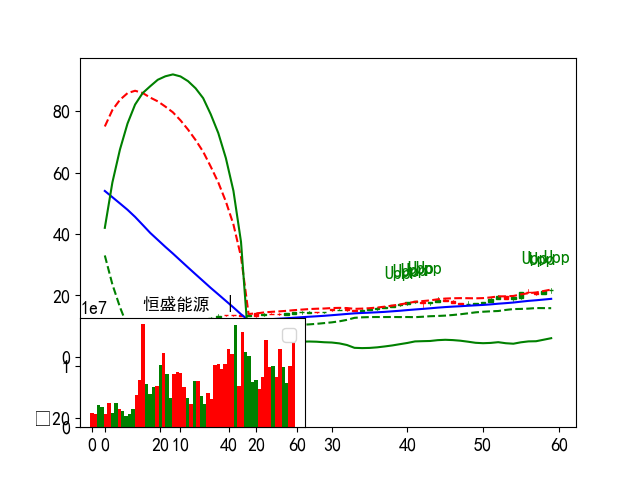

603848 1.95
xratio:0.21 ra_diff:1.95
code: 603848


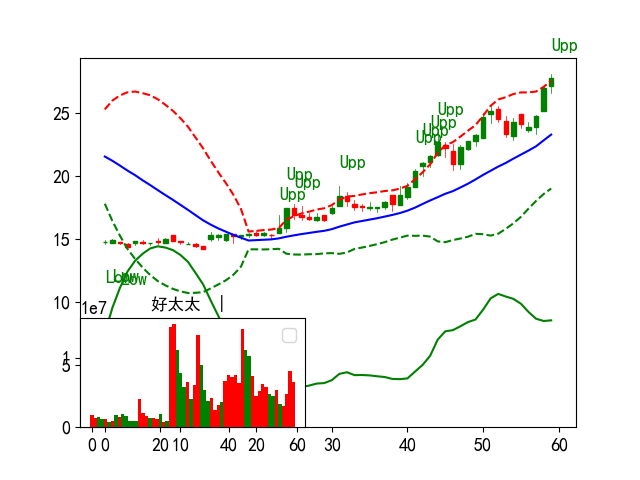

601288 1.37
xratio:0.03 ra_diff:1.37
code: 601288


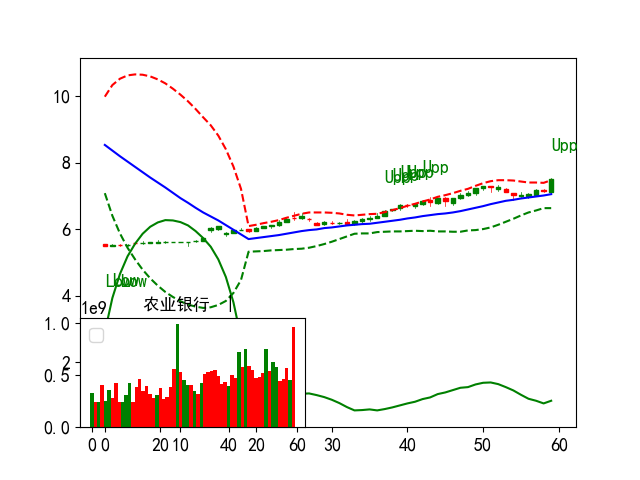

300450 2.25
xratio:0.25 ra_diff:2.25
code: 300450


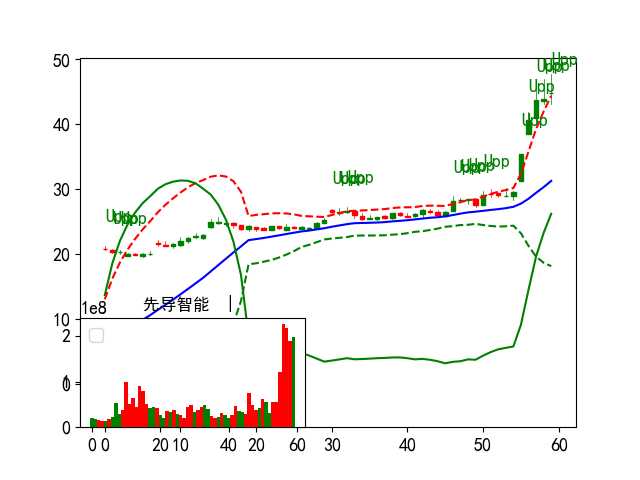

000524 1.38
xratio:0.04 ra_diff:1.38
code: 000524


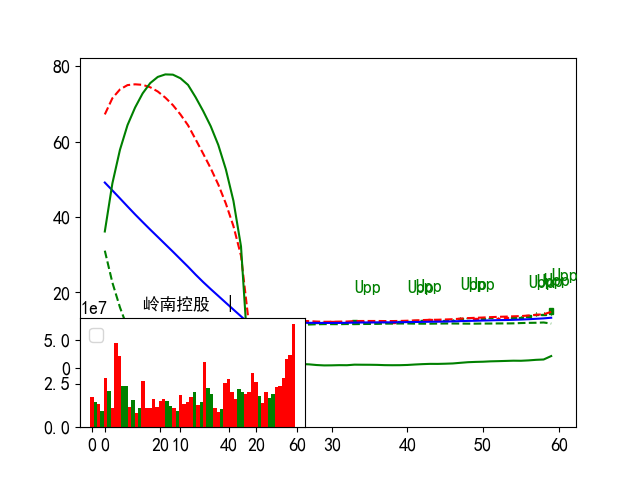

600330 1.66
xratio:0.05 ra_diff:1.66
code: 600330


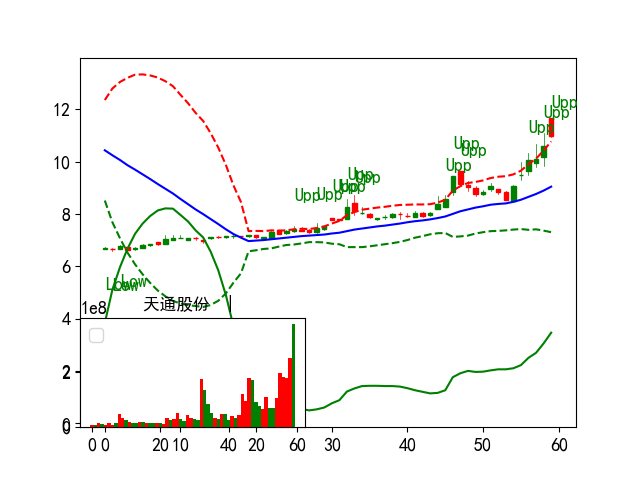

600603 1.36
xratio:0.03 ra_diff:1.36
code: 600603


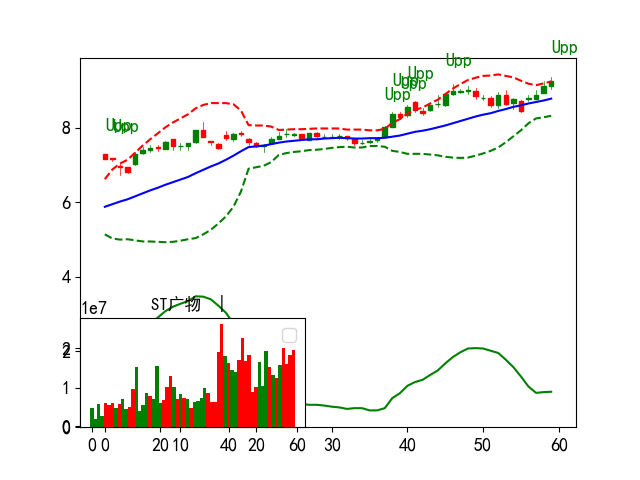

600021 2.15
xratio:0.13 ra_diff:2.15
code: 600021


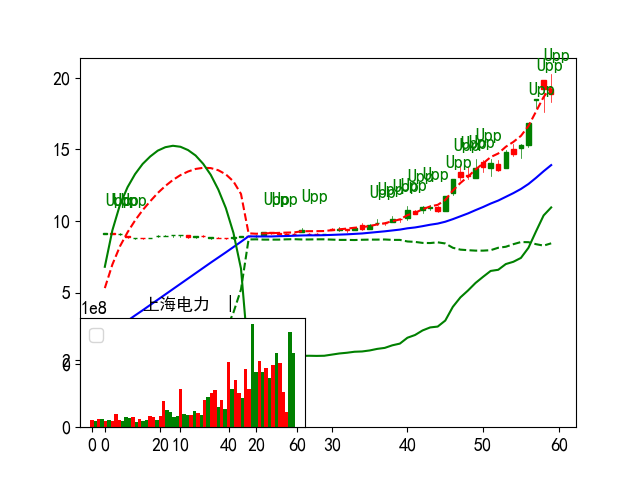

002558 2.45
xratio:0.3 ra_diff:2.45
code: 002558


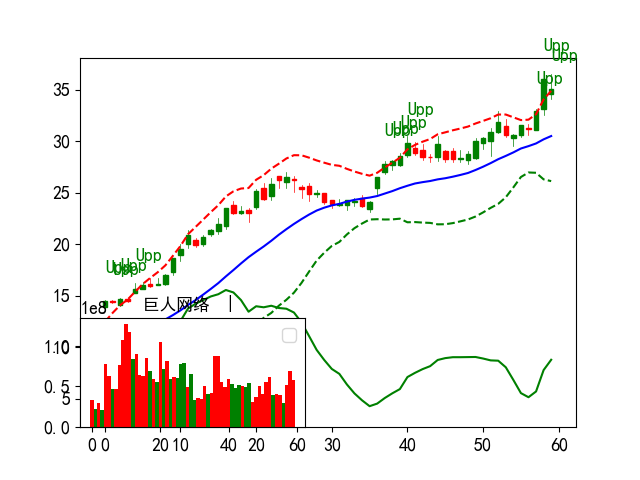

603903 1.63
xratio:0.05 ra_diff:1.63
code: 603903


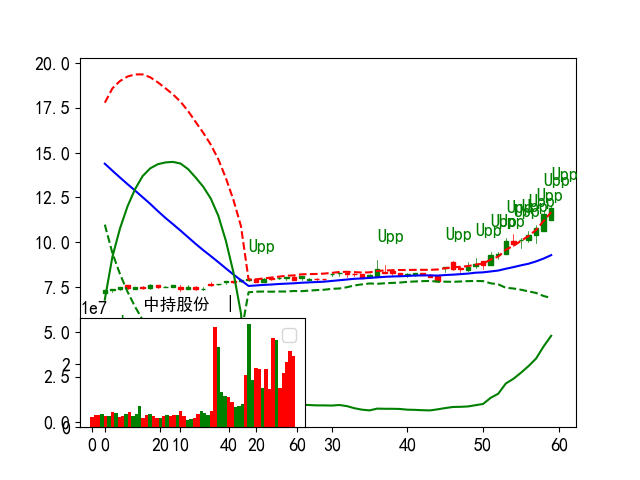

002796 1.39
xratio:0.07 ra_diff:1.39
code: 002796


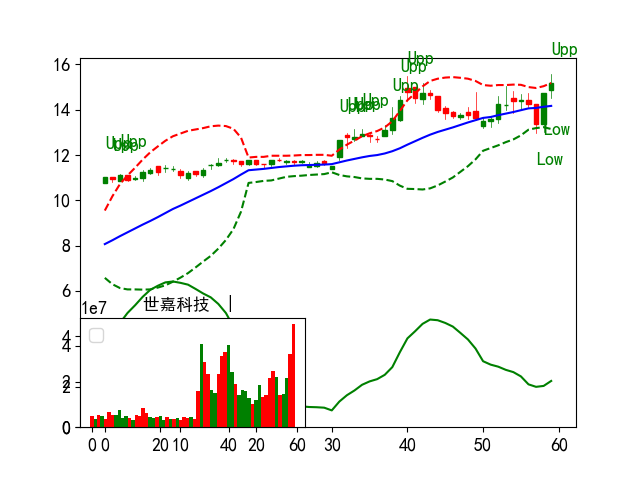

002691 1.25
xratio:0.02 ra_diff:1.25
code: 002691


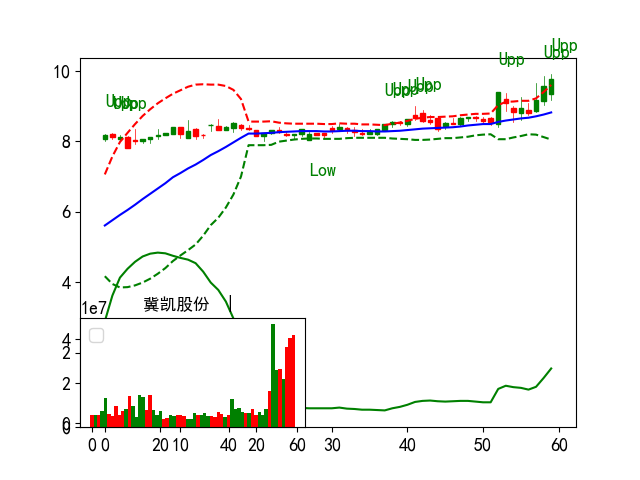

002175 1.25
xratio:0.01 ra_diff:1.25
code: 002175


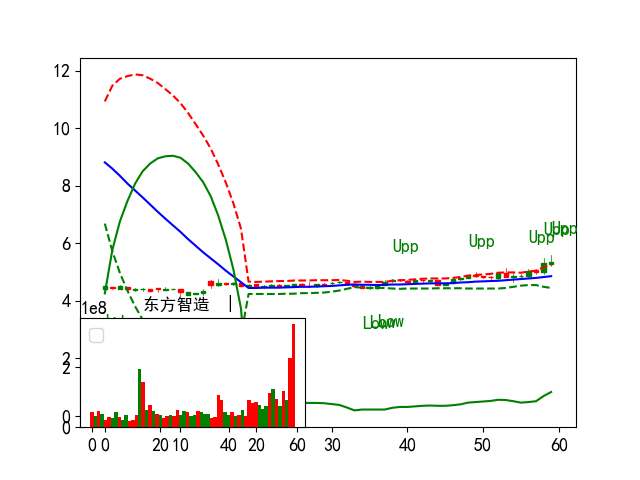

300014 1.58
xratio:0.18 ra_diff:1.58
code: 300014


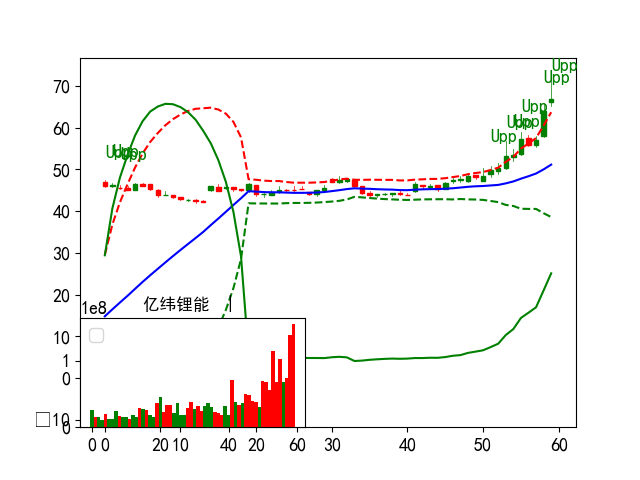

300274 1.92
xratio:0.79 ra_diff:1.92
code: 300274


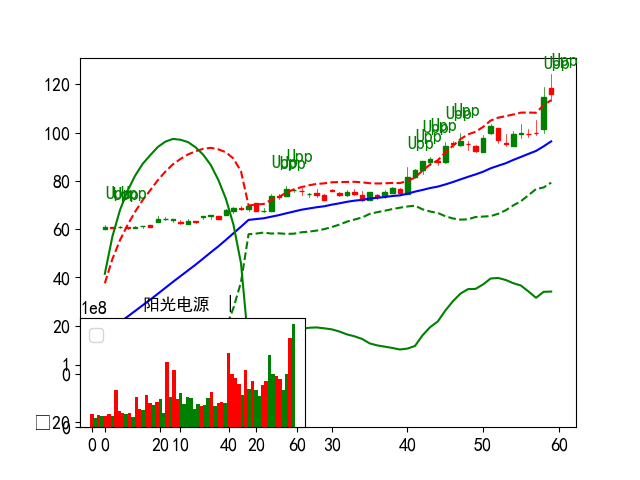

301312 1.95
xratio:0.38 ra_diff:1.95
code: 301312


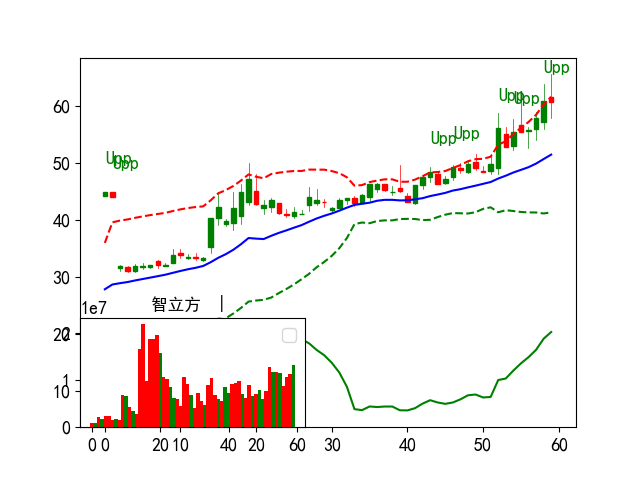

300832 1.2
xratio:0.02 ra_diff:1.2
code: 300832


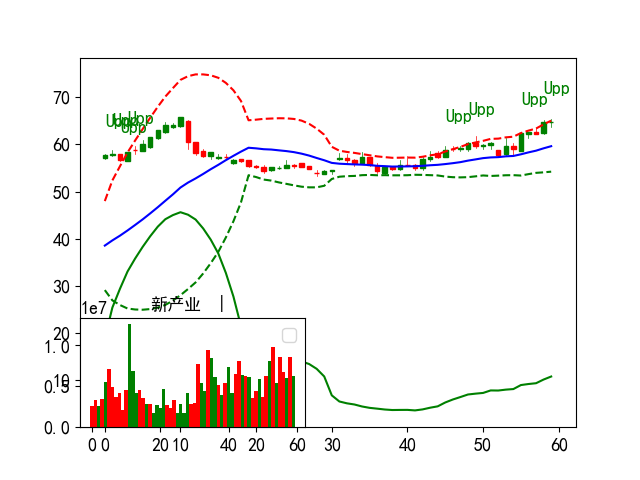

002846 1.74
xratio:0.08 ra_diff:1.74
code: 002846


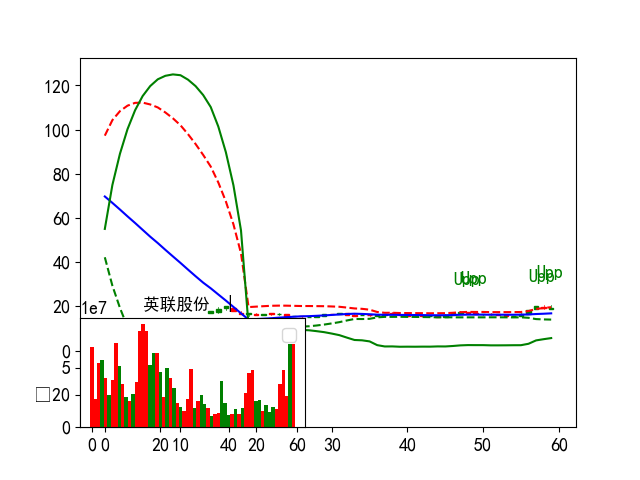

In [94]:
print("df_mask_hmax:%s"%(len(df_mask_hmax)))
for co in df_mask_hmax.index[:20]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

###  df_masklastd 068
    show_ohlc_upper(dfs.loc[co][-60:])

df_masklastd:22
300827 1.53
xratio:-0.05 ra_diff:1.53
code: 300827


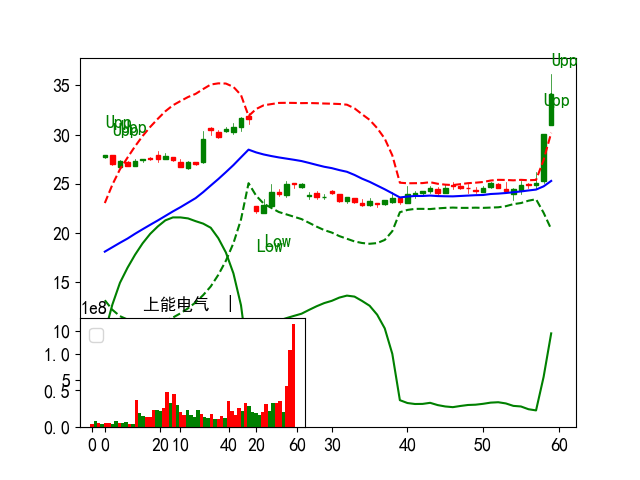

601069 1.53
xratio:0.02 ra_diff:1.53
code: 601069


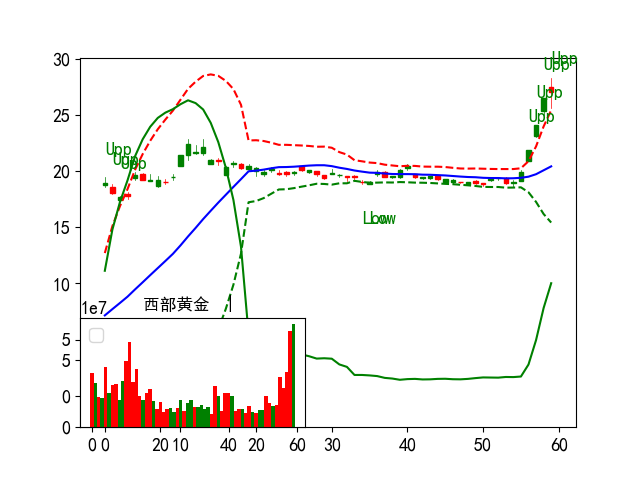

002150 1.49
xratio:0.05 ra_diff:1.49
code: 002150


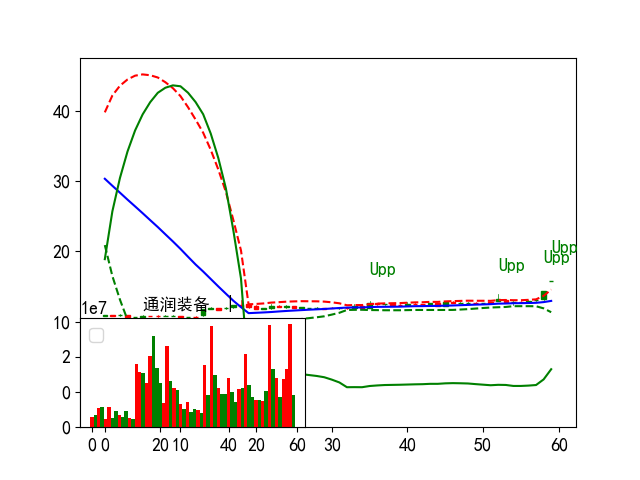

300014 1.58
xratio:0.18 ra_diff:1.58
code: 300014


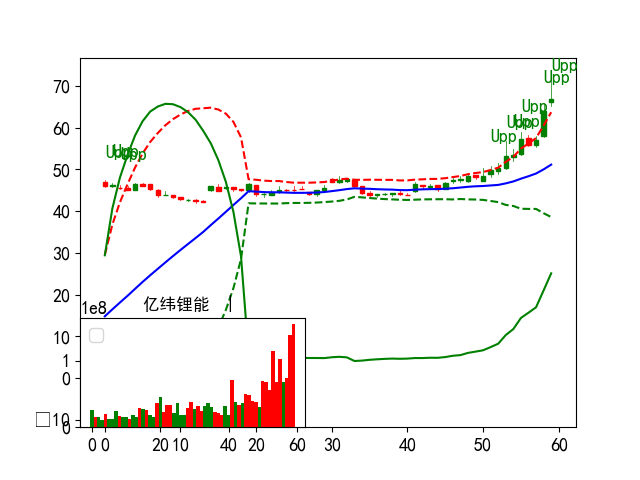

002975 1.97
xratio:0.43 ra_diff:1.97
code: 002975


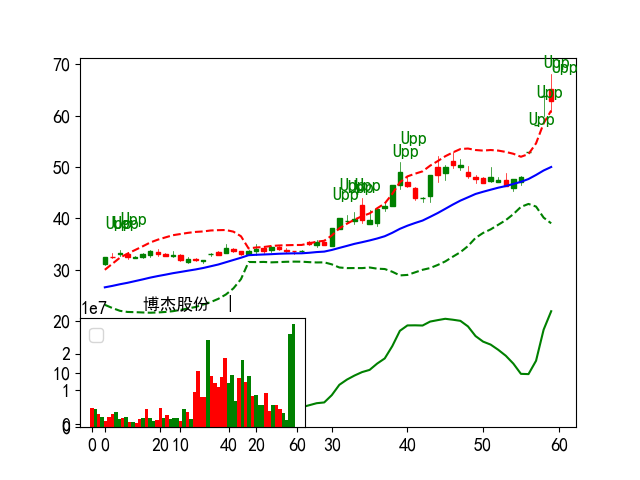

603099 1.76
xratio:0.18 ra_diff:1.76
code: 603099


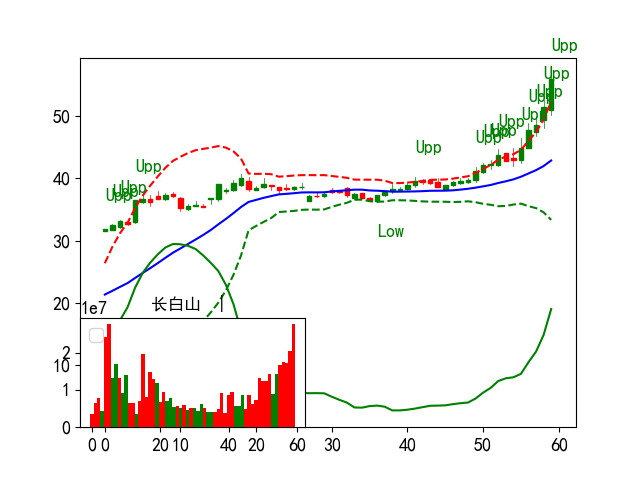

300274 1.92
xratio:0.79 ra_diff:1.92
code: 300274


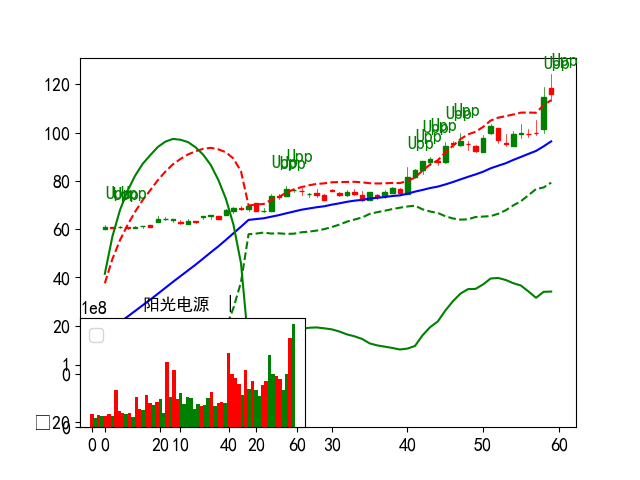

603848 1.95
xratio:0.21 ra_diff:1.95
code: 603848


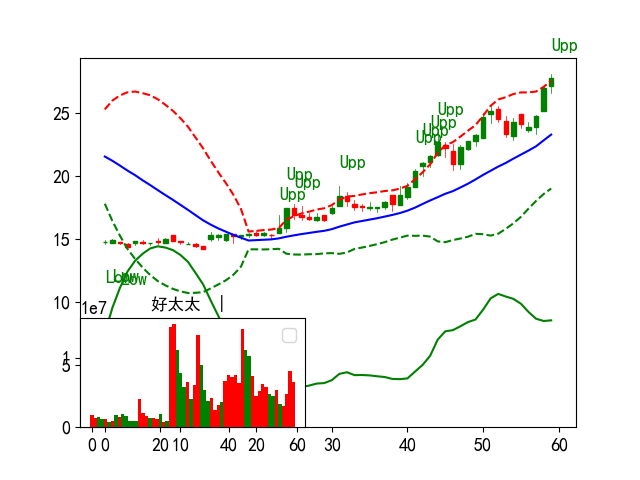

300919 1.39
xratio:0.11 ra_diff:1.39
code: 300919


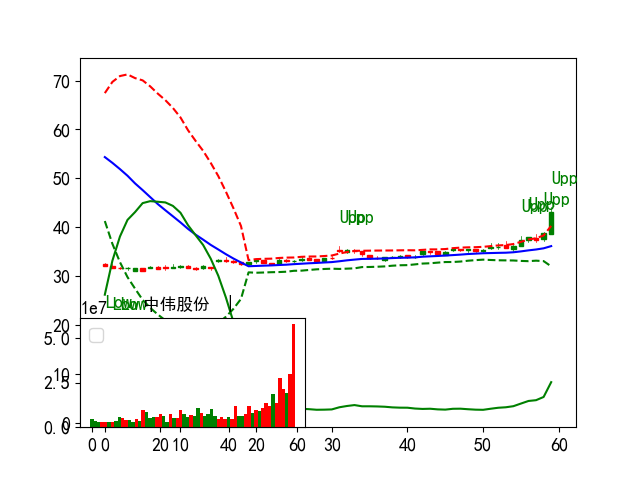

600721 1.56
xratio:0.04 ra_diff:1.56
code: 600721


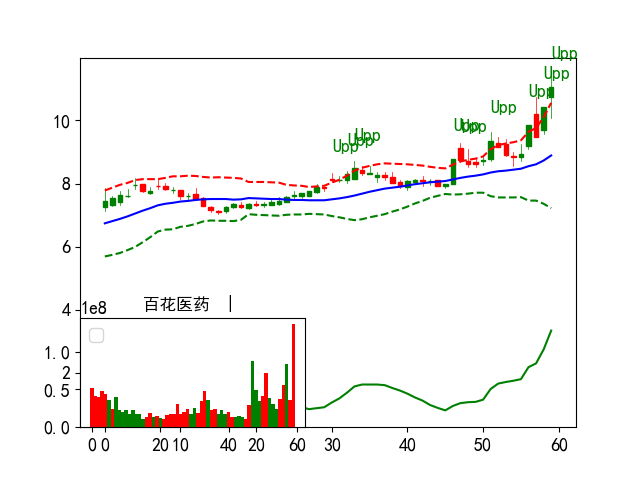

In [95]:
print("df_masklastd:%s"%(len(df_masklastd)))
for co in df_masklastd.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Cross_hmax_250 068

In [96]:
# dfs.loc[code_t].ma5
cross_hmax_250 = [co for co in df_masklastd.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_masklastd.loc[cross_hmax_250],limit=5)

cross_hamx:18
Count:18 40


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                          
300827  上能电气      1 2025-09-04  13.32     1.53    0.21   9.53   9.79  34.12   
601069  西部黄金      4 2025-09-04   2.22     1.53    0.18   8.25  10.02  27.11   
002150  通润装备      1 2025-09-04  10.00     1.49    0.07   3.18   3.23  15.84   
300014  亿纬锂能      4 2025-09-04   4.50     1.58    0.80  18.38  25.10  66.88   
002975  博杰股份      2 2025-09-04  -1.72     1.97    0.56  15.94  21.93  62.78   

        volsum5d  ...   ma20  ma250   llow  vol1d    vol2d   vol3d  vol4d  \
code              ...                                                       
300827     253.1  ...  25.29  17.90  31.00  34.95    86.58  164.21 -41.18   
601069     227.9  ...  20.44  13.73  25.61   7.75    74.67   39.59 -21.89   
002150      49.3  ...  12.95  15.63  15.84 -69.35    79.26   20.79  56.47   
300014     126.5  ...  51.14  19.58  65.25  12.76    87.99    8.44 -34.14   
002975    1083.5  ...  49.99  34.42  60.62  11.42  1158.77  -48.76 -20.49   

         vol5d  perc3d  perc5d  
code                            
300827    8.56   37.14   39.55  
601069  127.82   23.73   42.24  
002150  -37.83   21.94   23.27  
300014   51.45   19.69   24.94  
002975  -17.41   18.88   31.56  

[5 rows x 23 columns]

df_mask250 cross_hmax_250:18
300919 1.39
xratio:0.11 ra_diff:1.39
code: 300919


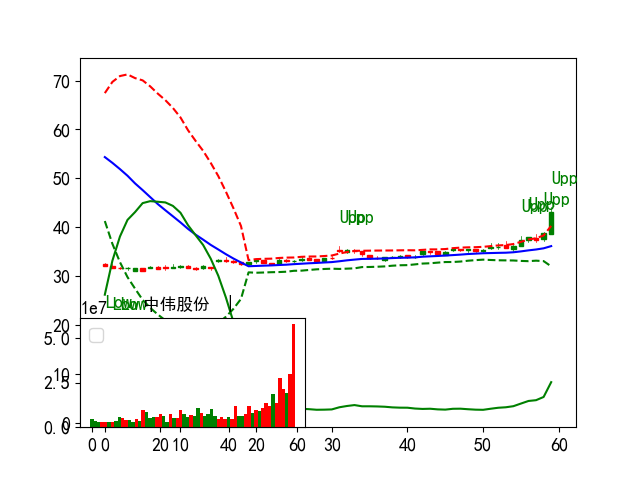

600250 1.54
xratio:0.02 ra_diff:1.54
code: 600250


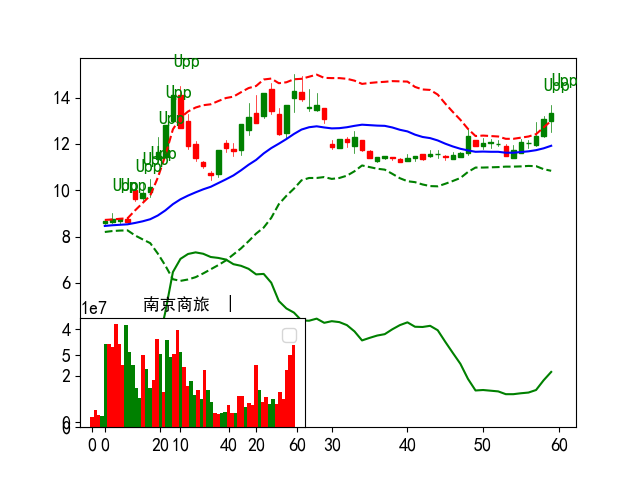

600593 1.37
xratio:0.1 ra_diff:1.37
code: 600593


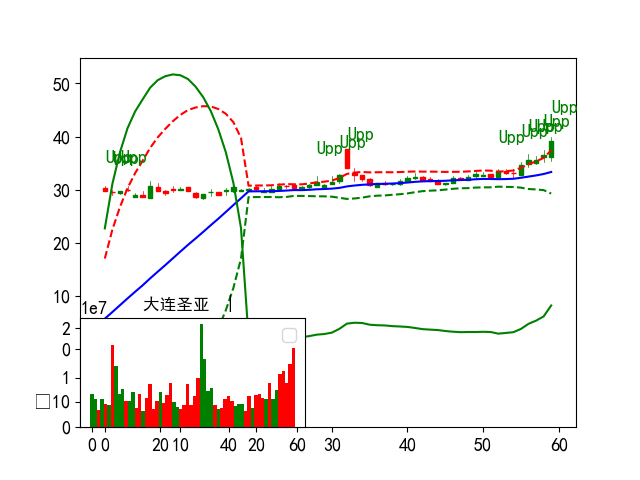

605117 1.34
xratio:-0.27 ra_diff:1.34
code: 605117


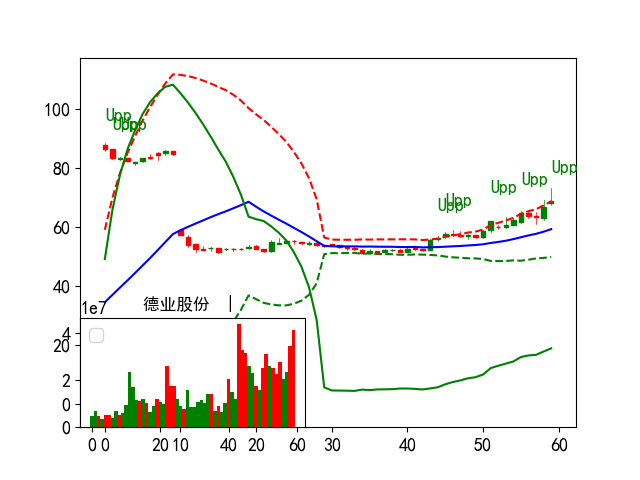

300763 1.46
xratio:0.28 ra_diff:1.46
code: 300763


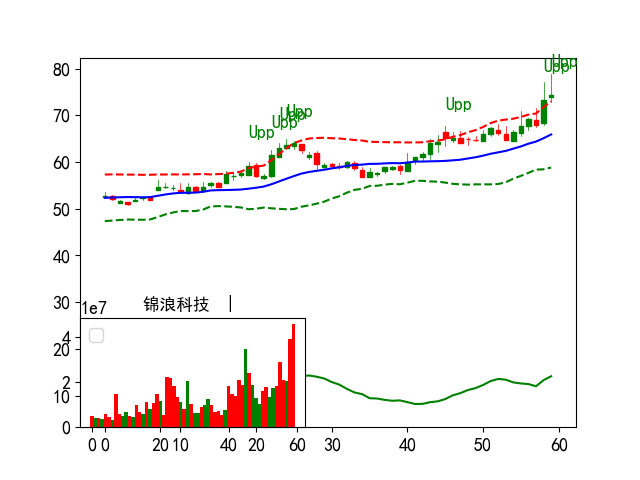

603595 1.44
xratio:0.05 ra_diff:1.44
code: 603595


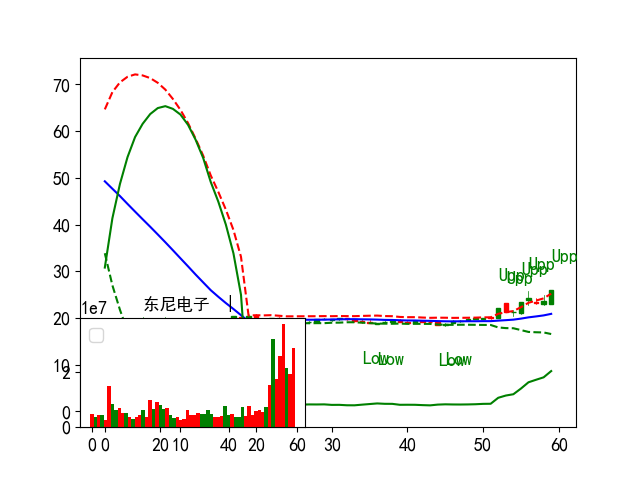

002487 1.32
xratio:0.09 ra_diff:1.32
code: 002487


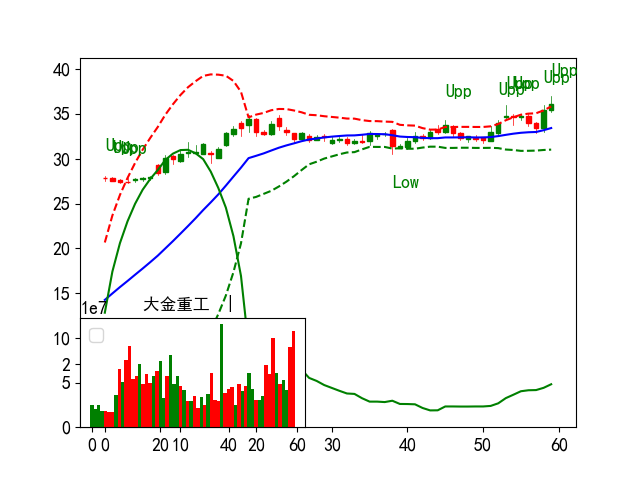

300035 1.62
xratio:0.1 ra_diff:1.62
code: 300035


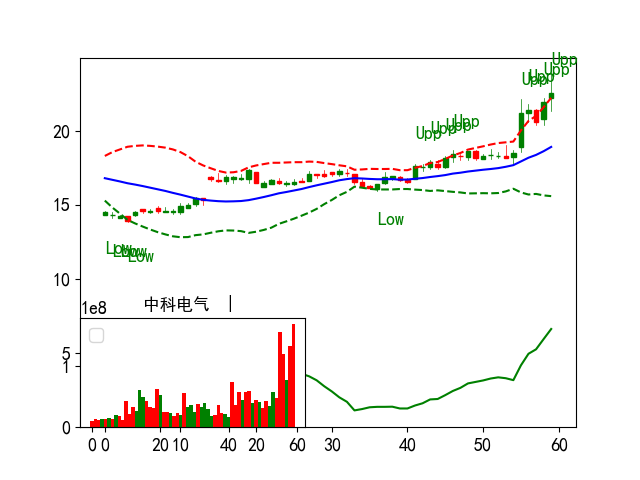

600826 1.69
xratio:0.09 ra_diff:1.69
code: 600826


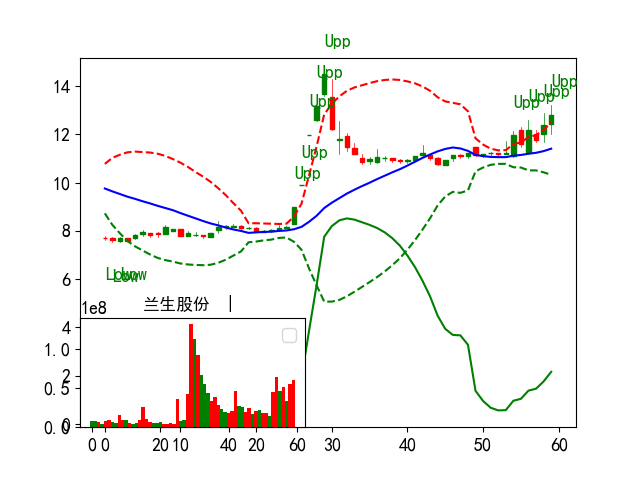

001215 1.15
xratio:0.03 ra_diff:1.15
code: 001215


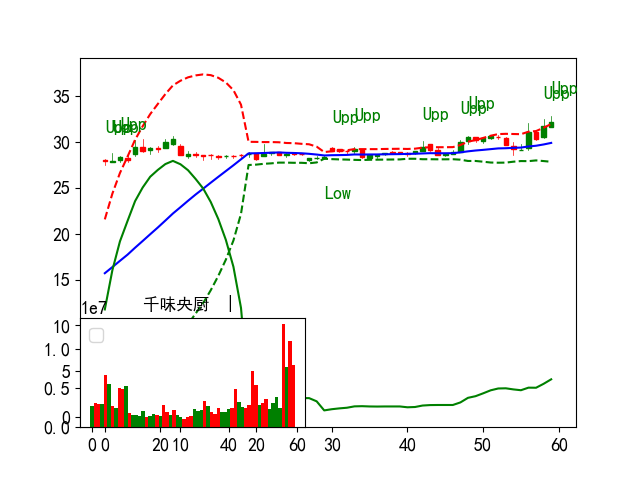

In [97]:
print("df_mask250 cross_hmax_250:%s"%(len(cross_hmax_250)))
# dfs.loc['000002'].shape
for co in cross_hmax_250[-10:]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

## 写入061

In [98]:
# write_code_to_blk(df_masklastd.index.tolist(),'061')
# hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)].index.tolist()
hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) ].index.tolist()
print(len(cross_hmax_250))
# write_code_to_blk(cross_hmax_250,'068')
# write_code_to_blk(hmax_code,'061')

18


In [99]:
# print(df_masklastd.loc['301255'].date)

# 默认年线筛选

In [100]:
top_temp.shape
top_temp.index

(242, 36)

Index(['603713', '600021', '301369', '300308', '300724', '605288', '603979',
       '601717', '600673', '600580',
       ...
       '301488', '002165', '002053', '688062', '600079', '603051', '600900',
       '600007', '688559', '300457'],
      dtype='object', name='code', length=242)

## plt.close('all')

In [101]:
# plt.close('all')

# 写入060